# **Fairness in Classification on the COMPAS dataset**

> A group project by **Anna Krysta**, **Manar Shehazi** and **Andrei Ilin**

The aim of this project is to analyze the **COMPAS** dataset to understand biases in recidivism predictions and building classifiers with a focus on fairness. The **COMPAS** dataset includes demographic and criminal history data for defendants in Broward County, Florida, during 2013 and 2014. This data set has been criticized for biases against certain racial groups, which we will explore and attempt to mitigate.



## Dataset Exploration and Bias Analysis



In [21]:
%matplotlib inline

import urllib.request
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# load the data set
df = pd.read_csv("compas-scores-two-years.csv")

In [22]:
#preprocessing of the data set
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

# Conversion to dictionary with np arrays
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

### <span style='font-size:medium'>Now, let us analyze the data. Our goal is to present that the </span><span style='font-size:medium'>**COMPAS**</span><span style='font-size:medium'> classifier is indeed biased. To achieve this, we consider the following two columns: decile\_score and score\_text. The former's range is from 1 to 10, while the latter's values are low, medium, and high. First, we analyze the data in terms of the decile\_score column.</span>

<span style='font-size:medium'>To investigate potential racial biases in the COMPAS scoring system, we analyzed the distribution of decile scores across two major racial groups: African Americans and Caucasians.</span>


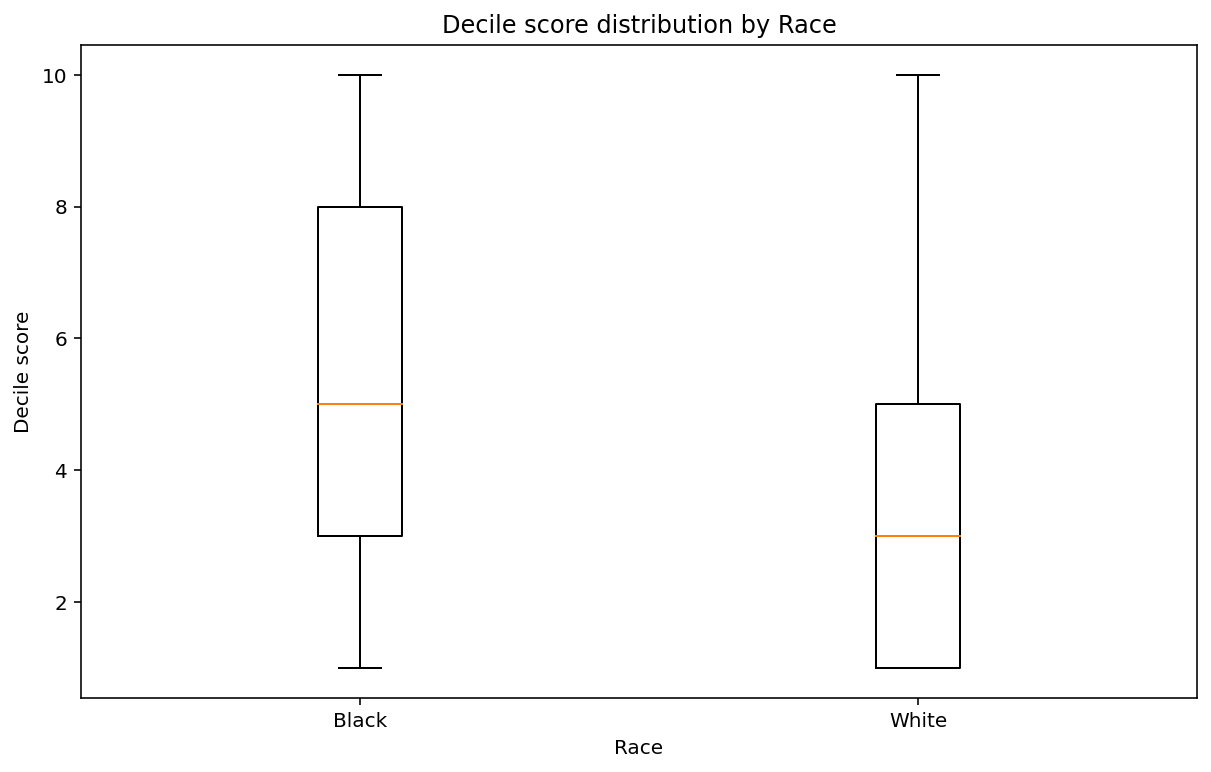

In [23]:
# Decile score distribution by Race
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['race'] == 'African-American']['decile_score'], df[df['race'] == 'Caucasian']['decile_score']], labels=['Black', 'White'])
plt.title('Decile score distribution by Race')
plt.xlabel('Race')
plt.ylabel('Decile score')
plt.show()

<span style='font-size:medium'>Some observations that we can derive from the resulting boxplot are:</span>

- <span style='font-size:medium'>The </span><span style='font-size:medium'>**median decile score**</span><span style='font-size:medium'> \(orange line\) for Black defendants ~5 appears to be higher than that for White defendants ~3. This suggests that, on average, Black defendants are assigned to higher risk of recidivism compared to White ones.</span>
- <span style='font-size:medium'>**Interquartile Range**</span><span style='font-size:medium'>: The </span><span style='font-size:medium'>**IQR**</span><span style='font-size:medium'> represented by the length/height of the box refers to 50% of the data.  A larger </span><span style='font-size:medium'>**IQR**</span><span style='font-size:medium'> for one group would suggest more variability in COMPAS scores within that group.  It looks like both groups have a similar </span><span style='font-size:medium'>**IQR**</span><span style='font-size:medium'>, but the box for the Black group is shifted upwards, indicating higher scores across the middle 50% of data points. This indicates that 50% of Black defendants have decile_score range between 3 and 8 meanwhile this range is from 1 to 5 for White ones. This suggest more variability in COMPAS scores within the Black group. We can also infer that 75% from White defendants have score less than 5, while 75% from Black defendants have score less than 8. This might be a sign of some existing bias.</span>
- <span style='font-size:medium'>The </span><span style='font-size:medium'>**whiskers**</span><span style='font-size:medium'> which are the lines extending from the boxes that indicate the range of the data. The White group has no bottom whisker and thus it is positively skewed. That is, the scores are more concentrated at the lower end of the scores. For the Black group, the whiskers are approximately equal, indicating that the data is more or less symmetric about the center.</span>
- <span style='font-size:medium'>**Outliers**</span><span style='font-size:medium'>: Neither Black nor White shows any suspiciously far out values. </span>
- <span style='font-size:medium'>AM USING THOSE LINKS TO INTERPRET</span>
- https://www.open.edu/openlearn/mod/oucontent/view.php?printable=1&id=4089 
- https://www.nagwa.com/en/explainers/812192146073/ 



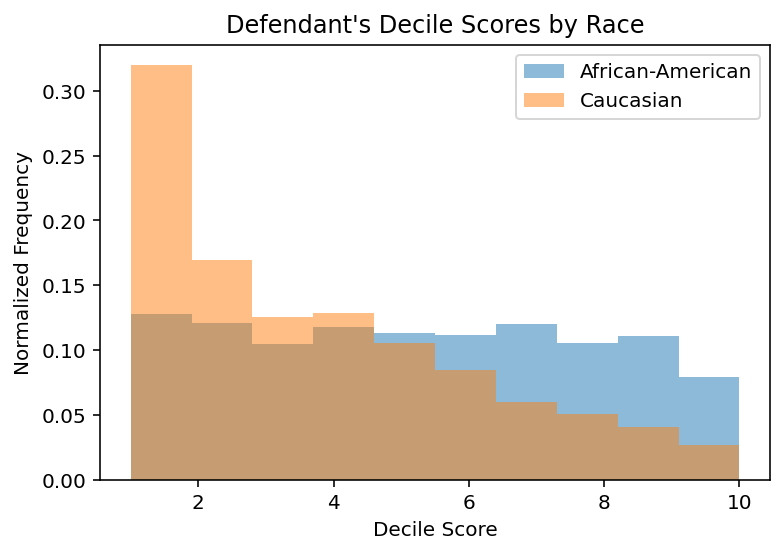

In [6]:
df[df.race == 'African-American']['decile_score'].plot(kind = 'hist', bins=10, alpha=0.5, density=True, label='African-American')
df[df.race == 'Caucasian']['decile_score'].plot(kind = 'hist', bins=10, alpha=0.5, density=True, label='Caucasian')

plt.title('Defendant\'s Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

<span style='font-size:medium'>In our study of the </span><span style='font-size:medium'>**COMPAS**</span><span style='font-size:medium'> decile scores, we used normalized histograms to explore the distribution of scores according to race. The graph shows the decile score frequencies for African\-American and Caucasian defendants. We notice that:</span>

- <span style='font-size:medium'>There exists a concentration of higher decile scores for African\-American defendants. Particularly, the frequency peaks at lower decile scores are much more prominent for Caucasians than for African\-Americans, suggesting that African\-Americans are more frequently assigned higher risk scores.</span>
- <span style='font-size:medium'>The distribution for African\-American defendants shows less frequency at the lowest risk scores \(1 and 2\) compared to Caucasians. Conversely, for the higher risk scores \(scores 8 through 10\), there is an elevated frequency for African\-American defendants.</span>
- <span style='font-size:medium'>Since the frequencies are normalized, the comparison accounts for any differences in group sizes, reinforcing that the observed disparities are not due to the number of observations but to the scores themselves. </span>
- <span style='font-size:medium'>So, as overall, we can see that African\-American defendants are more likely to receive higher risk scores than Caucasian defendants. This points to a potential bias in risk assessment, which could lead to unequal treatment in the judicial system.</span>



In [7]:
# Recidivism rate by race
recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race = recid_race.sort_values(by='rate', ascending=False)
recid_race[(recid_race.index == 'African-American') | (recid_race.index == 'Caucasian')]

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.52315
Caucasian,1281,822,0.39087


<span style='font-size:medium'>The calculated rates reveal a significant discrepancy between African\-American and Caucasian individuals. The recidivism rate for African\-American individuals is approximately 52.3%, while for Caucasians, it is around 39.1%. This suggests that African\-American individuals are recidivating at a higher rate than Caucasian individuals according to this dataset.</span>



##### Now, we analyze the second 'score\_text' column of the data. We show that it also exhibits bias regarding race.



In [8]:
# high risk rates by race
score_race = pd.crosstab(df.race, df.score_text)
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race[(score_race.index == 'African-American') | (score_race.index == 'Caucasian')]

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Caucasian,223,1407,473,0.106039


In [9]:
# Medium risk rates by race
score_race = pd.crosstab(df.race, df.score_text)
score_race['Medium risk rate'] = score_race['Medium'] / score_race.sum(axis=1)
score_race[(score_race.index == 'African-American') | (score_race.index == 'Caucasian')]

score_text,High,Low,Medium,Medium risk rate
race,,,,
African-American,845,1346,984,0.309921
Caucasian,223,1407,473,0.224917


<span style='font-size:medium'>We analyzed the </span><span style='font-size:medium'>**'score\_text'**</span><span style='font-size:medium'> column, which categorizes defendants into '</span><span style='font-size:medium'>**High**</span><span style='font-size:medium'>', '</span><span style='font-size:medium'>**Low**</span><span style='font-size:medium'>', or '</span><span style='font-size:medium'>**Medium**</span><span style='font-size:medium'>' risk levels. Our findings demonstrate that African\-American individuals are classified as '</span><span style='font-size:medium'>**High**</span><span style='font-size:medium'>' risk at a rate more than twice that of Caucasians \(approximately 26.6% vs. 10.6%\). In addition to examining the 'High risk rate', we have also calculated the '</span><span style='font-size:medium'>**Medium**</span><span style='font-size:medium'> risk </span><span style='font-size:medium'>**rate**</span><span style='font-size:medium'>' to provide a more complete picture of the COMPAS risk assessments across racial lines. Our analysis reveals that approximately 30.99% of African\-American individuals are designated as 'Medium' risk, compared to 22.49% of Caucasian individuals. This significant disparity cannot be overlooked as it suggests that the COMPAS system's risk categories may disproportionately affect African\-American individuals.</span>


<Axes: xlabel='decile_score'>

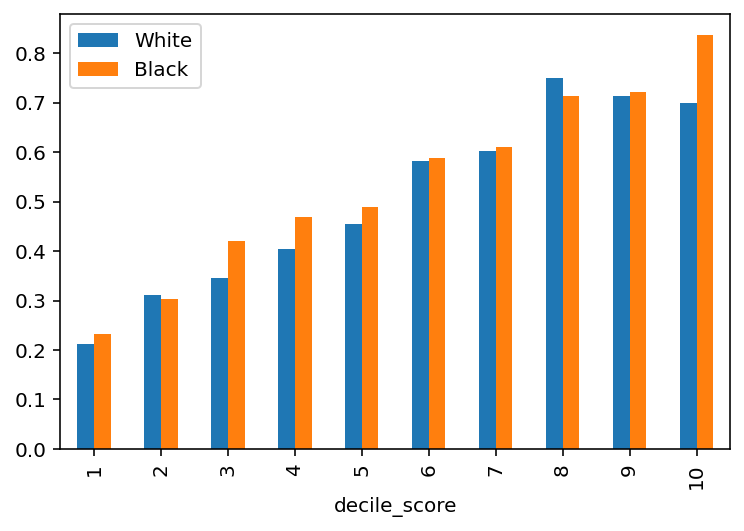

In [10]:
filtered_data = df[df.race=='African-American'].select_dtypes(include='number')
filtered_data1 = df[df.race=='Caucasian'].select_dtypes(include='number')
b = filtered_data.groupby(df.decile_score).mean()['two_year_recid']
w = filtered_data1.groupby(df.decile_score).mean()['two_year_recid']

a = pd.concat([w,b], axis=1)
a.columns = ['White','Black']
a.plot.bar()

<span style='font-size:medium'>In this analysis, we chose to compare the mean rates of two\-year recidivism between African\-American and Caucasian individuals across each decile score. The bar chart presents these comparisons, showing different patterns in the predicted likelihood of recidivism as assigned by the decile scores. We can see that, on average,  African\-American individuals have higher recidivism rates than Caucasian individuals at nearly every decile score level. This disparity is particularly evident at the higher end of the decile score spectrum.</span>


In [11]:
from IPython.display import display
# COMPAS recidivism confusion matrix
df['guessed_recid'] = df.score_text != 'Low'
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid)
print('Confusion matrix')
display(cm) # for "confusion matrix"

# cm is a confusion matrix. The rows are guessed, the columns are actual 
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]  
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    display(cm)
    print()
    print_ppv_fpv(cm)   
    
print('White')
subset = df[df.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = df[df.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)

Confusion matrix


guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


White


actual,False,True
guessed,,
False,999,408
True,282,414



Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black


actual,False,True
guessed,,
False,873,473
True,641,1188



Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298



- <span style='font-size:medium'>The confusion matrix for each group shows the number of true positives \(</span><span style='font-size:medium'>**TP**</span><span style='font-size:medium'>\), true negatives \(</span><span style='font-size:medium'>**TN**</span><span style='font-size:medium'>\), false positives \(</span><span style='font-size:medium'>**FP**</span><span style='font-size:medium'>\), and false negatives \(</span><span style='font-size:medium'>**FN**</span><span style='font-size:medium'>\).</span>
- <span style='font-size:medium'>For White individuals, the matrix indicates a lower </span><span style='font-size:medium'>**TP**</span><span style='font-size:medium'> rate and a higher </span><span style='font-size:medium'>**TN**</span><span style='font-size:medium'> rate than for Black individuals.</span>
- <span style='font-size:medium'>For Black individuals, both </span><span style='font-size:medium'>**FP**</span><span style='font-size:medium'> and </span><span style='font-size:medium'>**TP**</span><span style='font-size:medium'> rates are higher compared to White individuals.</span>
- <span style='font-size:medium'>The </span><span style='font-size:medium'>**accuracy**</span><span style='font-size:medium'> for White individuals is around 67.2%, while for Black individuals, it is slightly lower at around 64.9%.</span>
- <span style='font-size:medium'>**PPV**</span><span style='font-size:medium'> indicates how many of the positive \(recidivism\) predictions were correct. The </span><span style='font-size:medium'>**PPV**</span><span style='font-size:medium'> is higher for Black individuals at around 64.9% compared to 59.4% for White individuals. This could imply that the COMPAS tool is more precise in predicting recidivism for Black individuals.</span>
- <span style='font-size:medium'>**FPR**</span><span style='font-size:medium'> measures the proportion of non\-recidivists who were incorrectly predicted as recidivists. The </span><span style='font-size:medium'>**FPR**</span><span style='font-size:medium'> for Black individuals is much higher \(42.3%\) compared to White individuals \(22.0%\). This might show that Black individuals who did not recidivate are more likely to be wrongly assessed as high risk compared to the White ones.</span>
- <span style='font-size:medium'>**FNR**</span><span style='font-size:medium'> indicates the proportion of actual recidivists who were not identified by the tool. It's lower for Black individuals than White individuals, suggesting that COMPAS is less likely to miss identifying a Black individual who will recidivate.</span>



### Data preparation

In this section, we prepare the **COMPAS** dataset for the stages of our fairness analysis. Our focus is to evaluate whether the predictive performance of the COMPAS recidivism model varies across different racial groups and if so, to what extent this variation may indicate racial bias.



In [12]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision/target variable
SENSITIVE_ATTRS = ["race"]

#Separate the features and the target variable from the dataset
y = df[CLASS_FEATURE]
X = df[FEATURES_CLASSIFICATION]

# Encode categorical variables
for attr in FEATURES_CLASSIFICATION:
    if attr not in CONT_VARIABLES:
        enc_data = pd.get_dummies(X[attr], prefix=attr)
        X = pd.concat([X, enc_data], axis=1)
        X.drop(attr, axis=1, inplace=True)
    else:
        sc = preprocessing.StandardScaler()
        sc.fit(X.loc[:, [attr]])
        X.loc[:, [attr]] = sc.transform(X.loc[:, [attr]])

# Separate data for African-American, Caucasian, and other races
X_b = X[data["race"] == "African-American"]
y_b = y[data["race"] == "African-American"]
X_w = X[data["race"] == "Caucasian"]
y_w = y[data["race"] == "Caucasian"]
X_o = X[(data["race"] != "Caucasian") & (data["race"] != "African-American")]
y_o = y[(data["race"] != "Caucasian") & (data["race"] != "African-American")]

# for black
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)

# for white
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)

# for the remaining races
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, test_size=0.3, random_state=9012)

# all races combined together
X_train = pd.concat([X_train_b, X_train_w, X_train_o])
X_test = pd.concat([X_test_b, X_test_w, X_test_o])
y_train = pd.concat([y_train_b, y_train_w, y_train_o])
y_test = pd.concat([y_test_b, y_test_w, y_test_o])

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


clf_kn = KNeighborsClassifier(n_neighbors=15)
clf_tree = DecisionTreeClassifier()
clf_log = LogisticRegression(solver='lbfgs')
clf_svm = SVC(probability=True)
clf_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, solver = 'sgd')
clf_gb = GradientBoostingClassifier()

# traning of the models
clf_kn.fit(X_train, y_train)
clf_tree.fit(X_train, y_train)
clf_log.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_nn.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)

# predicting the answers
y_kn_pred = clf_kn.predict(X_test)
y_tree_pred = clf_tree.predict(X_test)
y_log_pred = clf_log.predict(X_test)
y_svm_pred = clf_svm.predict(X_test)
y_nn_pred = clf_nn.predict(X_test)
y_gb_pred = clf_gb.predict(X_test)


def printMetrics(method_title, test_data, pred_data):
    print(method_title)
    print("\tAccuracy ", accuracy_score(test_data, pred_data))
    print("\tPrecision ", precision_score(test_data, pred_data, zero_division=1))
    print("\tRecall ", recall_score(test_data, pred_data))
    print("\tF1 score", f1_score(test_data, pred_data))

print("Performance for each of the classifiers:\n")
printMetrics("Nearest Neighbors:", y_test, y_kn_pred)
printMetrics("Decision Tree:", y_test, y_tree_pred)
printMetrics("Logistic Regression:", y_test, y_log_pred)
printMetrics("Support Vector Machine:", y_test, y_svm_pred)
printMetrics("Neural Network:", y_test, y_nn_pred)
printMetrics("Gradient Boosting:", y_test, y_gb_pred)


Performance for each of the classifiers:

Nearest Neighbors:
	Accuracy  0.6546141392336752
	Precision  0.6337837837837837
	Recall  0.5596658711217184
	F1 score 0.5944233206590621
Decision Tree:
	Accuracy  0.6481381543443065
	Precision  0.6422018348623854
	Recall  0.5011933174224343
	F1 score 0.5630026809651475
Logistic Regression:
	Accuracy  0.6540744738262277
	Precision  0.6450662739322534
	Recall  0.522673031026253
	F1 score 0.5774555042847725
Support Vector Machine:
	Accuracy  0.6589314624932542
	Precision  0.6403269754768393
	Recall  0.5608591885441527
	F1 score 0.5979643765903307
Neural Network:
	Accuracy  0.6637884511602806
	Precision  0.656934306569343
	Recall  0.5369928400954654
	F1 score 0.5909389363099147
Gradient Boosting:
	Accuracy  0.6659471127900701
	Precision  0.6412903225806451
	Recall  0.5930787589498807
	F1 score 0.6162430254184749


<span style='font-size:medium'>After comparing the performance metrics of the various classifiers we chose, we can see that:</span>

- <span style='font-size:medium'>**Nearest Neighbors:**</span>
  <span style='font-size:medium'>Shows average overall performance with the lowest F1 score among all models, indicating a balance between precision and recall.</span>
- <span style='font-size:medium'>**Decision Tree:**</span>
  <span style='font-size:medium'>Shows a lower recall, suggesting that it is less effective at identifying true recidivists. However, its precision is indicating a relatively lower rate of false positives compared to other models.</span>
- <span style='font-size:medium'>**Logistic Regression:**</span>
  <span style='font-size:medium'>Provides similar accuracy to the Nearest Neighbors but with an improved balance between precision and recall, as evidenced by a higher F1 score, suggesting a more balanced classification performance.</span>
- <span style='font-size:medium'>**Support Vector Machine \(SVM\):**</span>
  <span style='font-size:medium'>shows a slightly better performance across all metrics compared to Nearest Neighbors and Decision Tree, with an F1 score reflecting a more balanced trade\-off between precision and recall</span>
- <span style='font-size:medium'>**Neural Network:**</span>
  <span style='font-size:medium'>Scores higher in precision than other models, indicating a strong ability to correctly label true recidivists but shows a relatively average ability to identify all actual cases of recidivism, as reflected in its recall.</span>
- <span style='font-size:medium'>**Gradient Boosting**</span><span style='font-size:medium'>: Shows the best overall accuracy and F1 score, which suggests it is the most effective model at the trade\-off between precision and recall out of all the models tested. It also has the second\-highest recall, indicating its capability to identify true recidivists.</span>



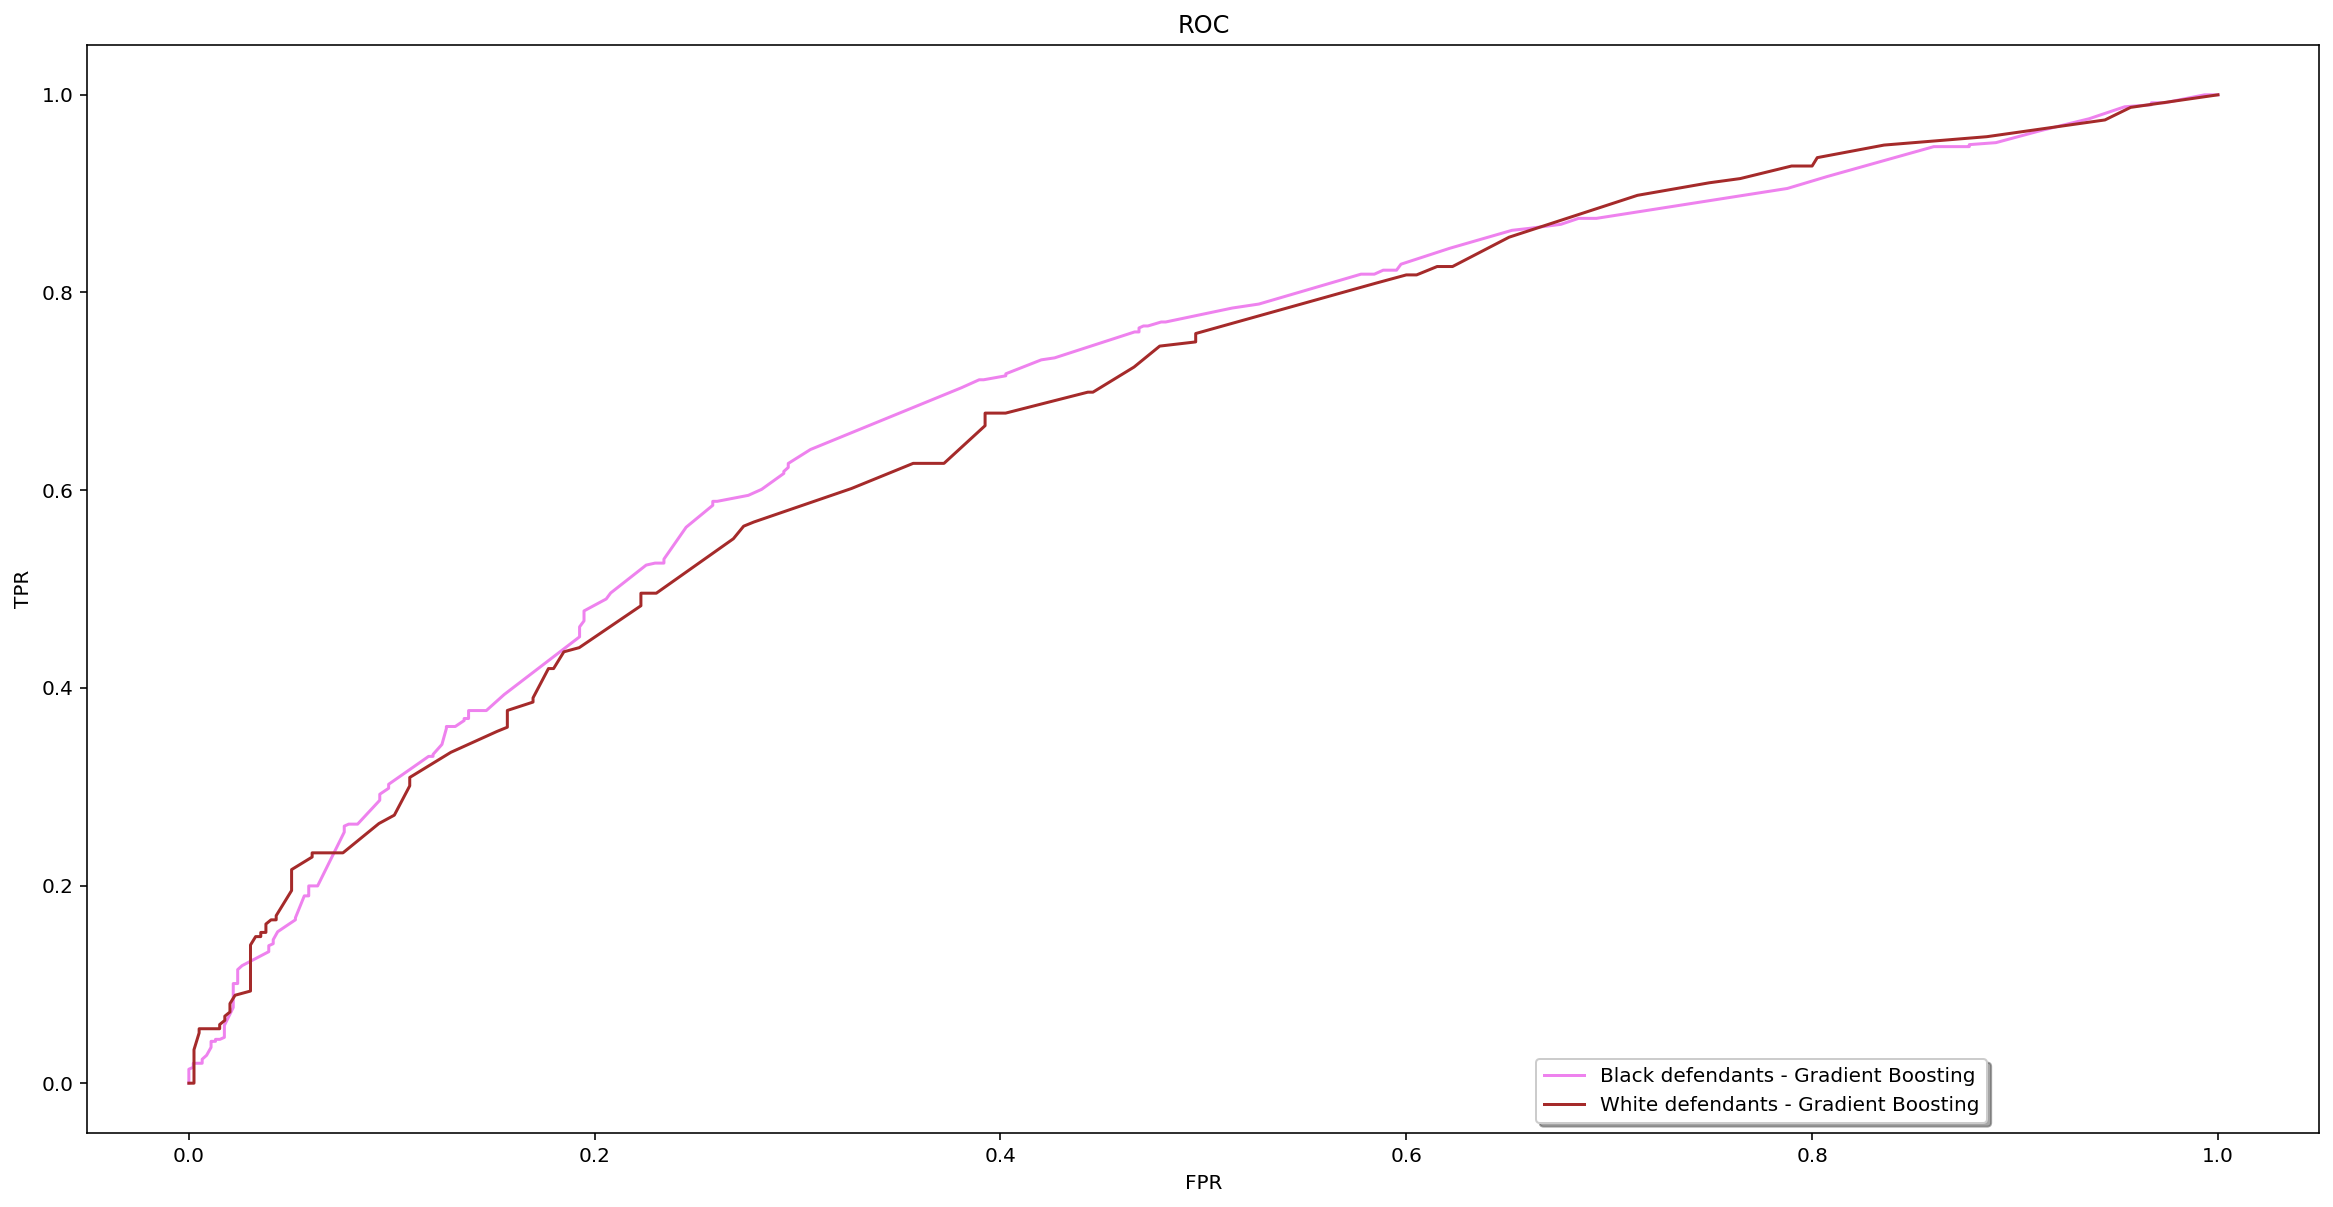

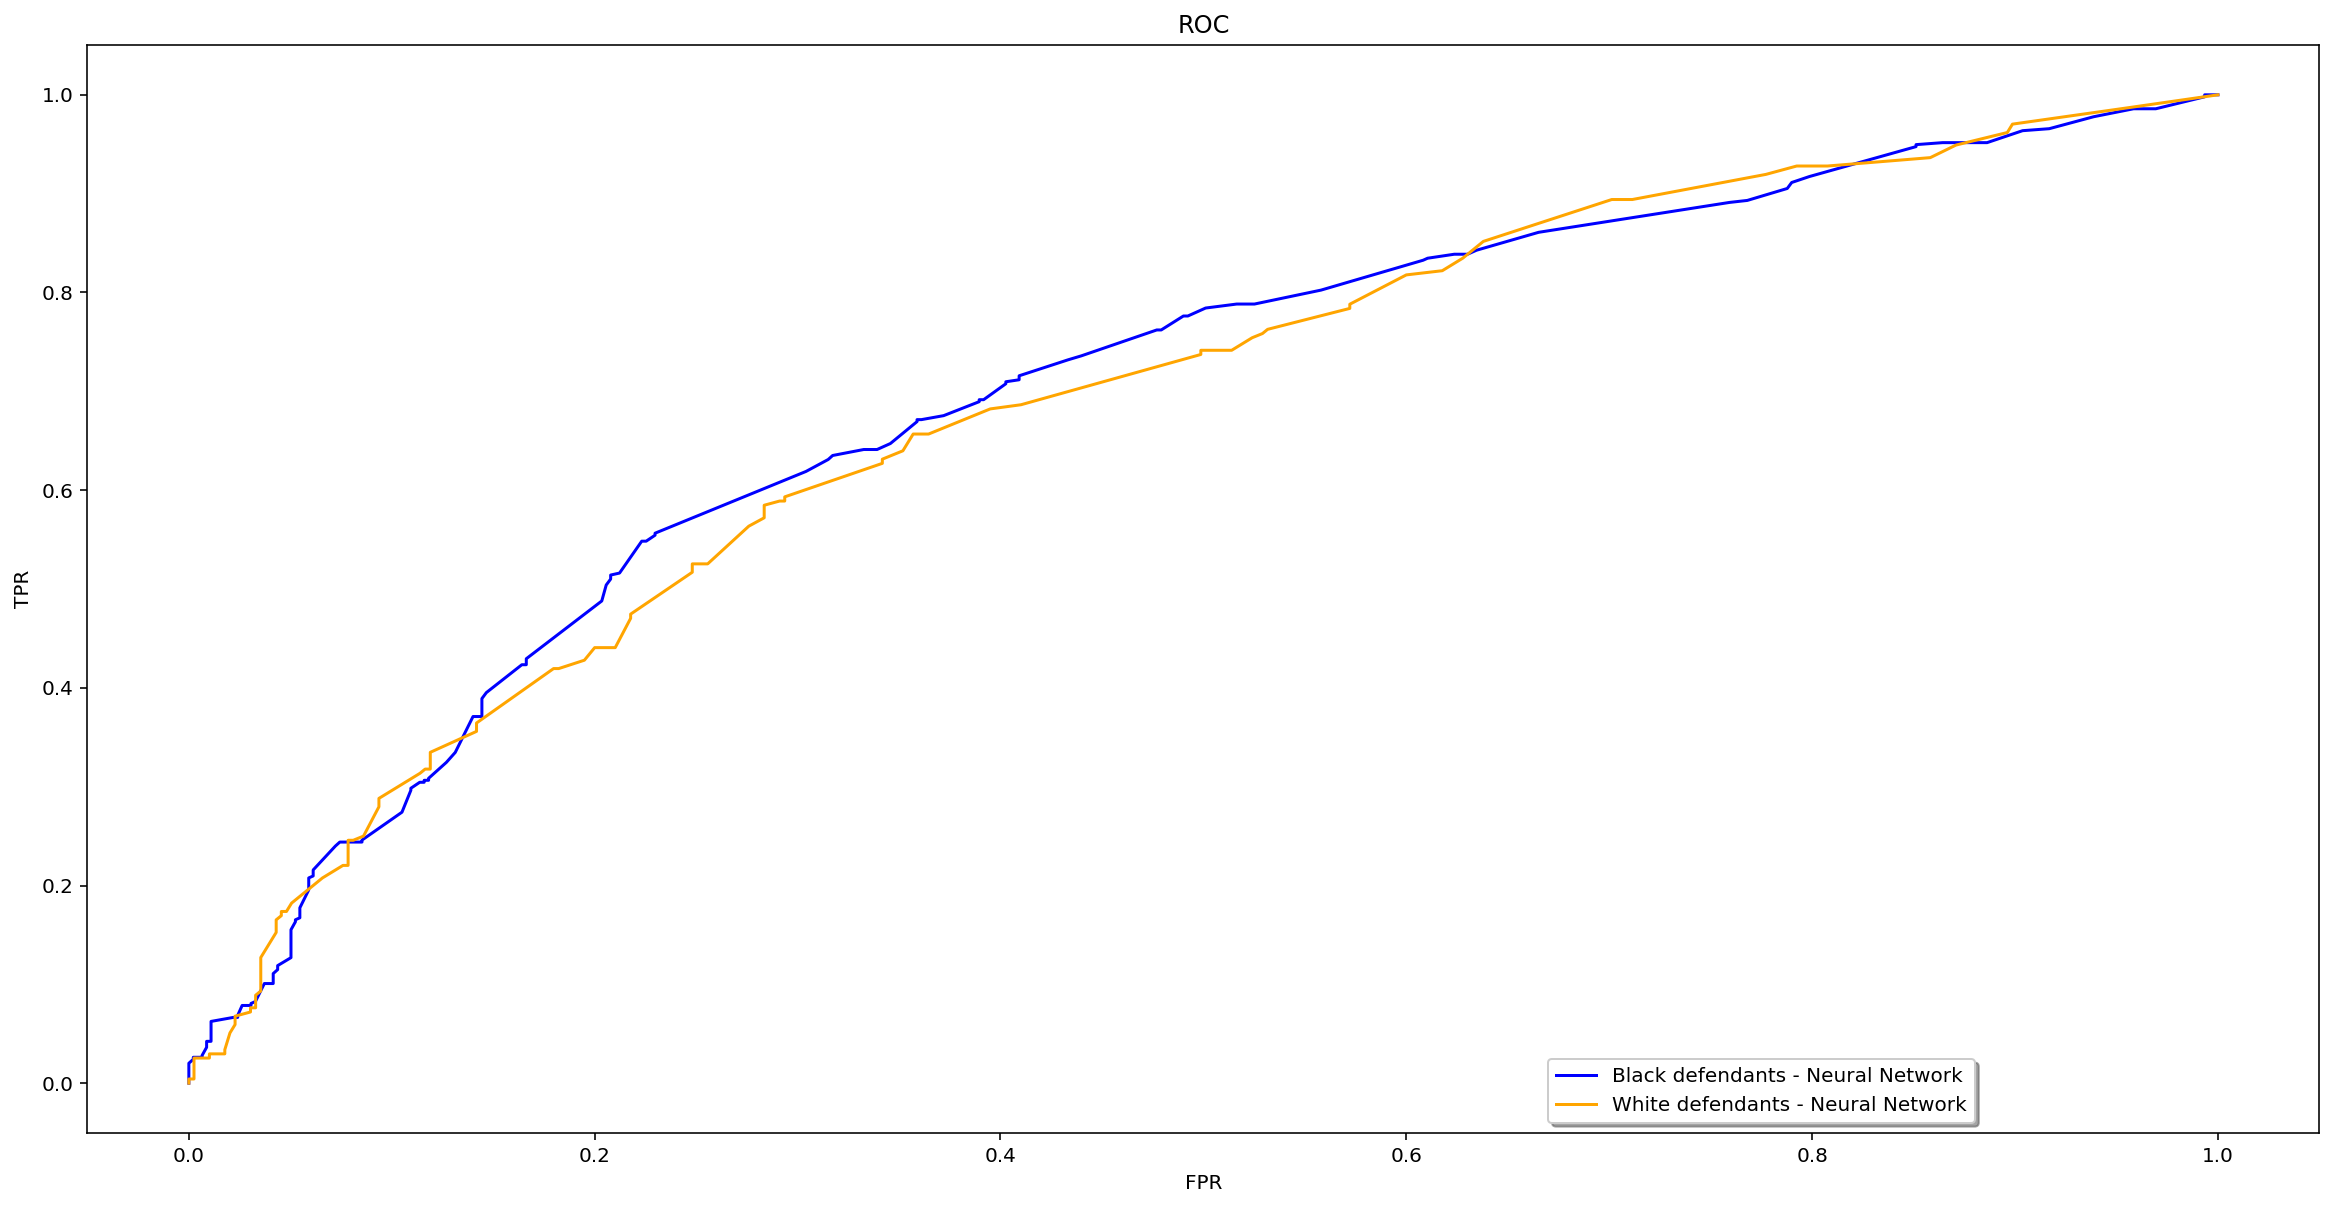

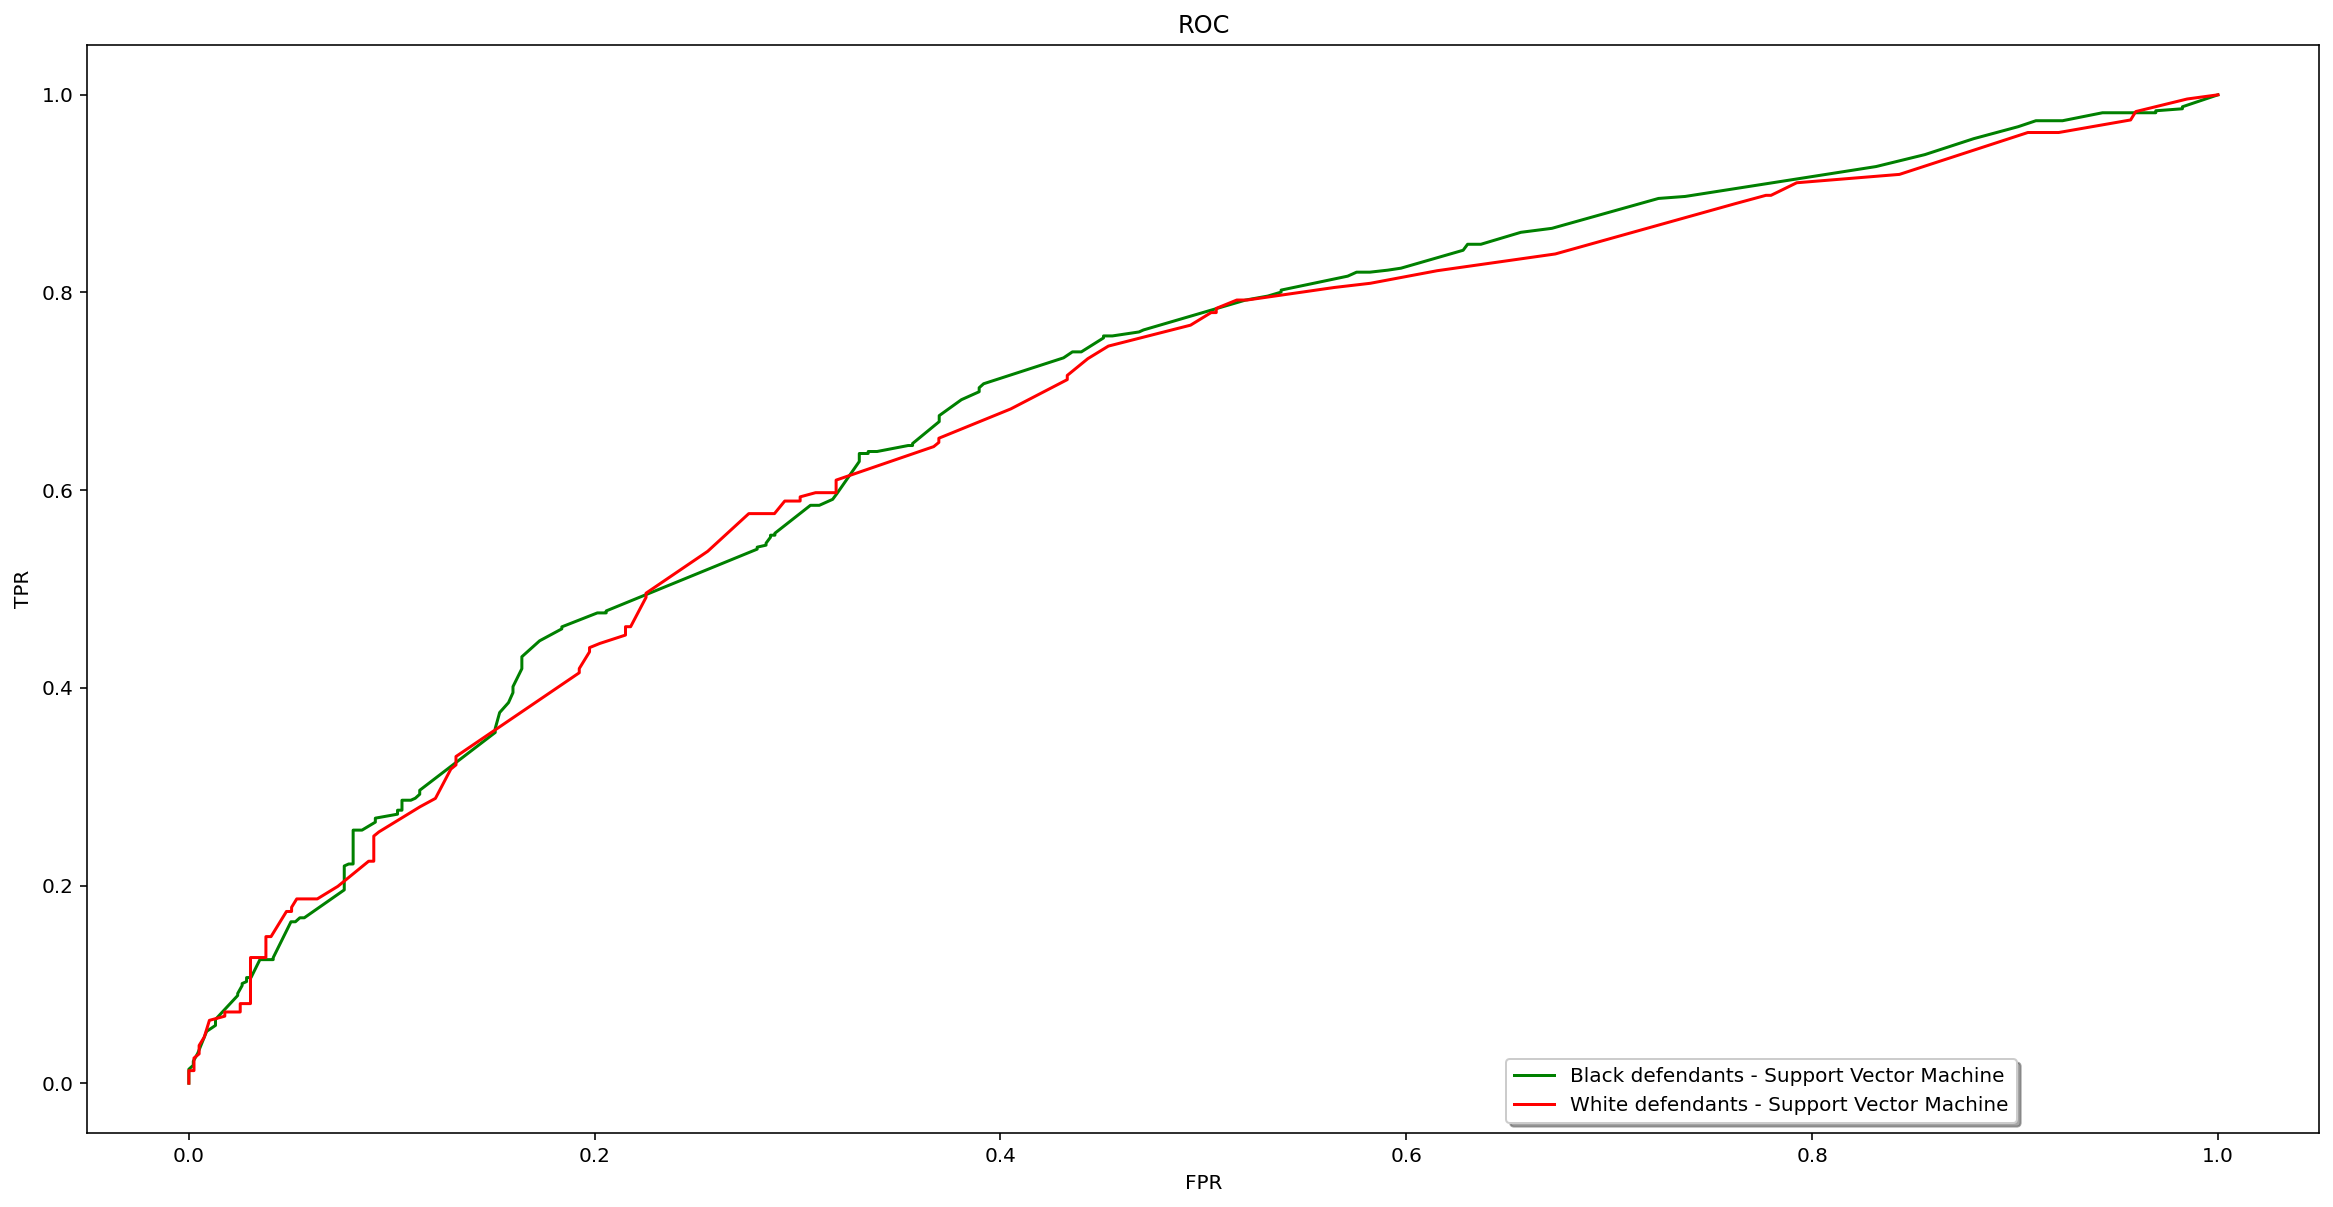

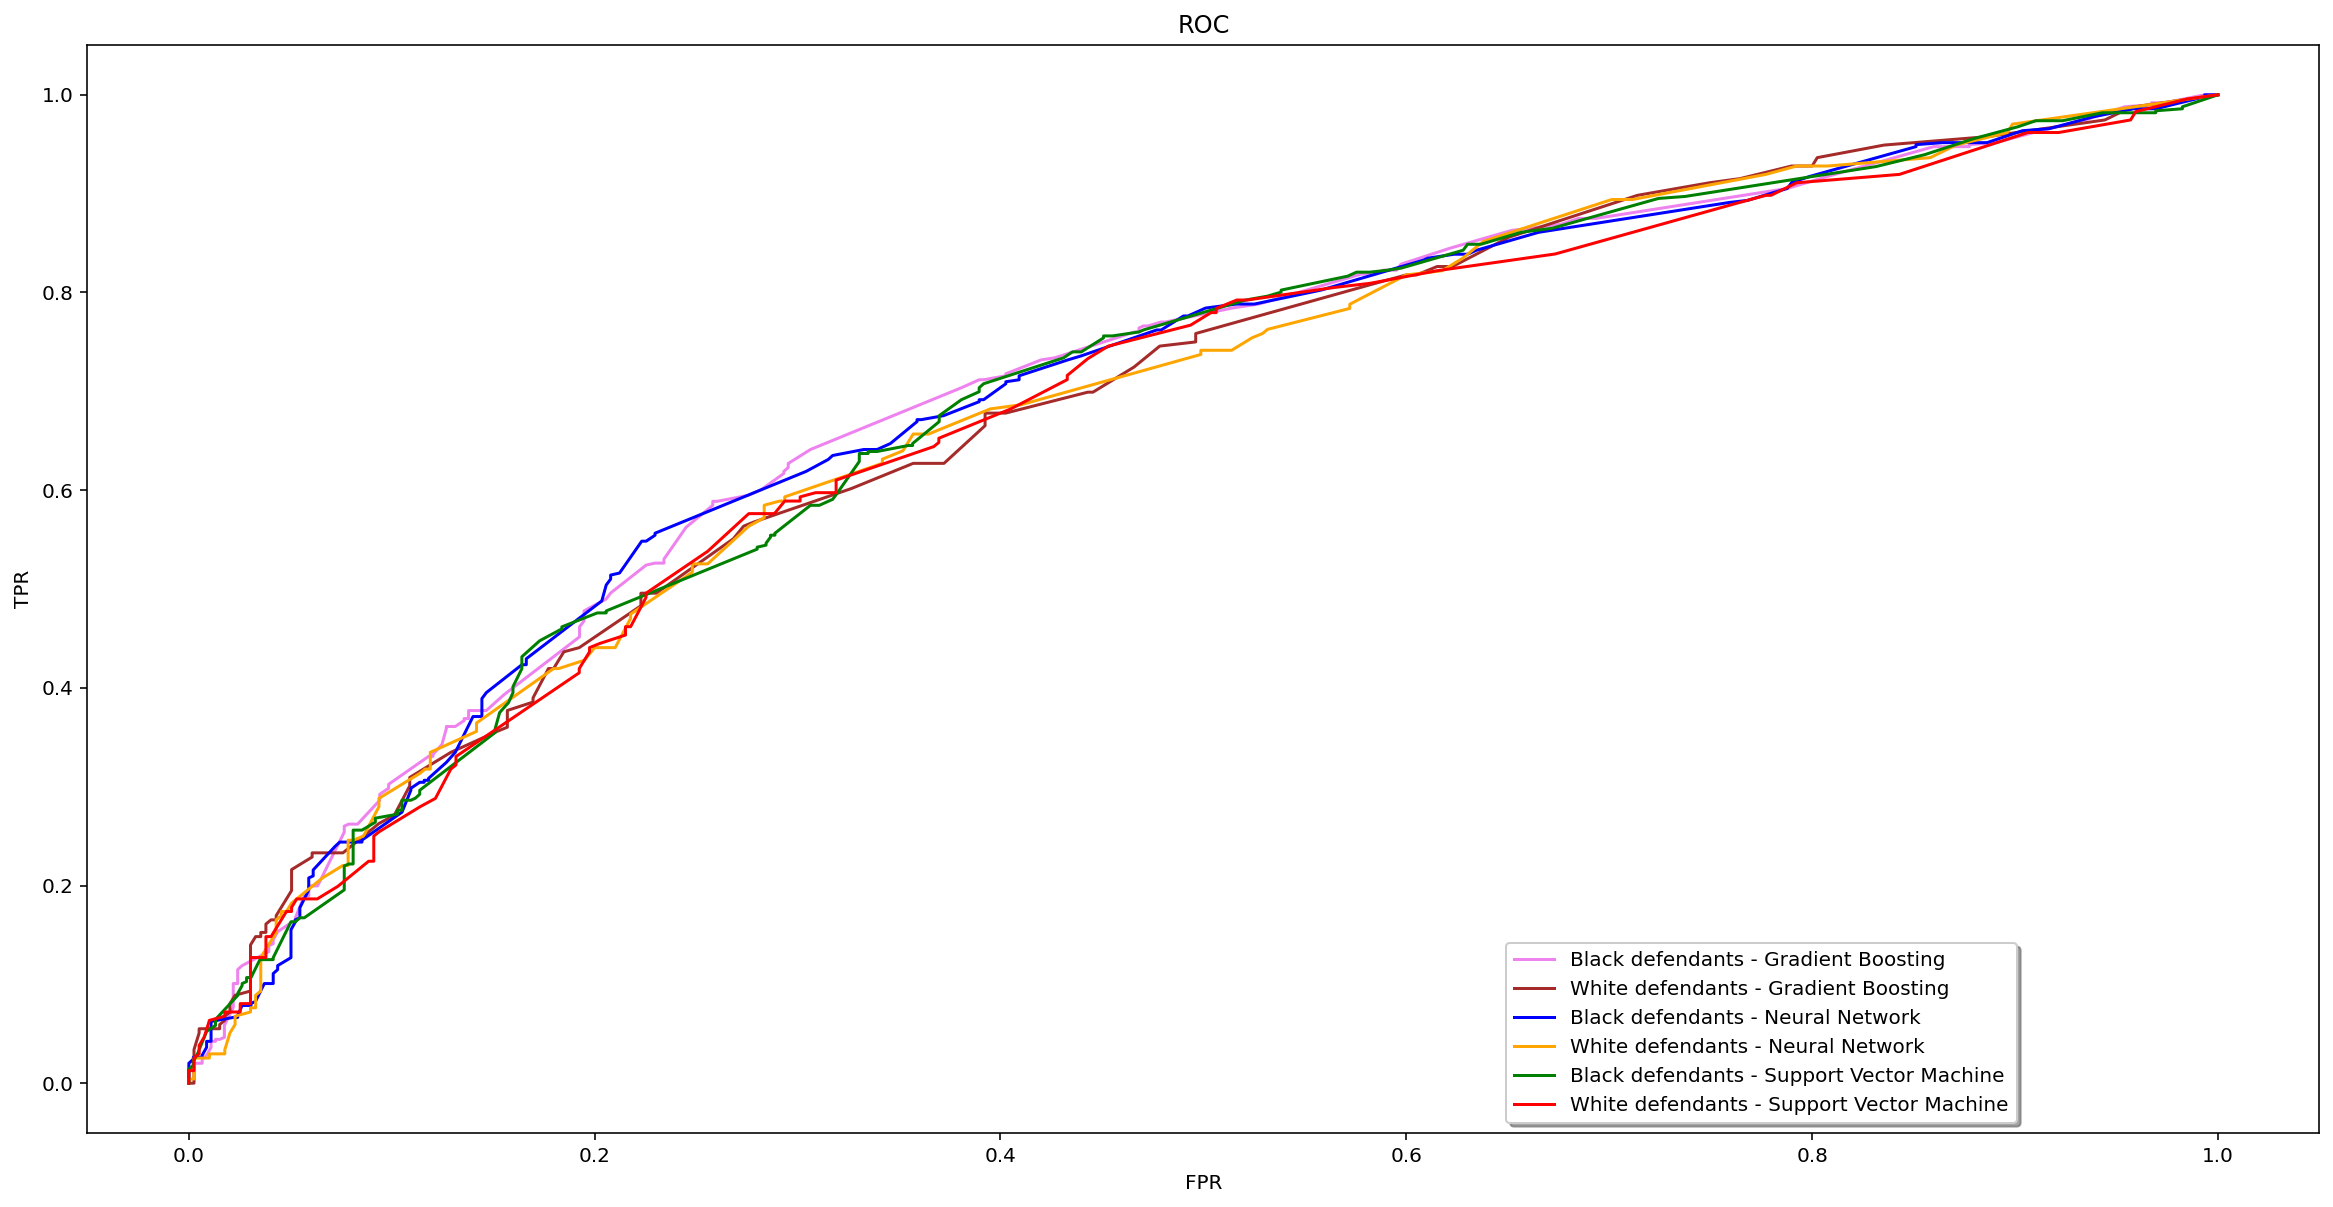

In [14]:
# ROC analysis
from sklearn.metrics import roc_curve

models = {}

models['Gradient Boosting'] = (clf_gb, 'violet', 'brown')
models['Neural Network'] = (clf_nn, 'blue', 'orange')
models['Support Vector Machine'] = (clf_svm, 'green', 'red')

# plotting ROC curve for each of the three most accurate models
for name, (model, color_b, color_w) in models.items():
    plt.figure(figsize=(20, 10))
    scores = model.predict_proba(X_test_b)
    fpr, tpr, _ = roc_curve(y_test_b, scores[:, 1])
    plt.plot(fpr, tpr, label='Black defendants - ' + name, color = color_b)

    # Get predictions for white defendants
    scores = model.predict_proba(X_test_w)
    fpr, tpr, _ = roc_curve(y_test_w, scores[:, 1])
    plt.plot(fpr, tpr, label='White defendants - ' + name, color = color_w)
    

    plt.title('ROC')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)
    plt.show()
    
# plotting ROC curve for all of the three most accurate models
plt.figure(figsize=(20, 10))
for name, (model, color_b, color_w) in models.items():
    scores = model.predict_proba(X_test_b)
    fpr, tpr, _ = roc_curve(y_test_b, scores[:, 1])
    plt.plot(fpr, tpr, label='Black defendants - ' + name, color = color_b)

    # Get predictions for white defendants
    scores = model.predict_proba(X_test_w)
    fpr, tpr, _ = roc_curve(y_test_w, scores[:, 1])
    plt.plot(fpr, tpr, label='White defendants - ' + name, color = color_w)   
    
plt.title('ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

Here, we try to evaluate the performance of various machine learning models with respect to their ability to classify individuals correctly as recidivist or non\-recidivist, with particular attention to potential racial biases in prediction accuracy. The models chosen for comparison include **Gradient Boosting**, **Neural Network**, and **Support Vector Machine**. For each model, the **ROC** curve is plotted twice: once for Black defendants and once for White defendants. The **ROC** curve is plotted as the True Positive Rate \(**TPR**\) against the False Positive Rate \(**FPR**\) at various threshold settings. The **ROC** analysis provides an assessment of model performance that considers both the rate at which the model correctly predicts recidivism \(sensitivity\) and the rate at which non\-recidivists are incorrectly classified as recidivists \(1\-specificity\). A model's fairness can be inferred from the similarity in these rates across different groups—indicative of equal treatment.

What we were able to observe is as follows:

- **Gradient Boosting:**
  The **ROC** curve for **Gradient Boosting** shows high True Positive Rate \(**TPR**\) for both Black and White defendants, indicating its strong performance in prediction.
  The curves are close together which means that that the model’s ability to distinguish between recidivist and non\-recidivist defendants does not differ a lot between the two groups. However, slight variations can indicate model bias.
- **Neural Network:**
  The **Neural Network**’s **ROC** curves for both groups also shows a high **TPR** but with some divergence between Black and White defendants. This implies potential differences in prediction accuracy.
  This also may suggest that the model performs better for one racial group over the other, thus raising concerns about fairness.
- **Support Vector Machine:**
  The **Support Vector Machine**’s **ROC** curves indicate similarity in performance for Black and White defendants. The overlapping lines suggests that there is no significant difference in the power of the model between these groups.



To go further in evaluating the predictive performance of classification models. We choose to use **Calibration Curves** that evaluates how well the predicted probabilities of an event \(like recidivism\) correspond to the true probabilities of that event. These curves show the relationship between the predicted probabilities and the actual outcomes.


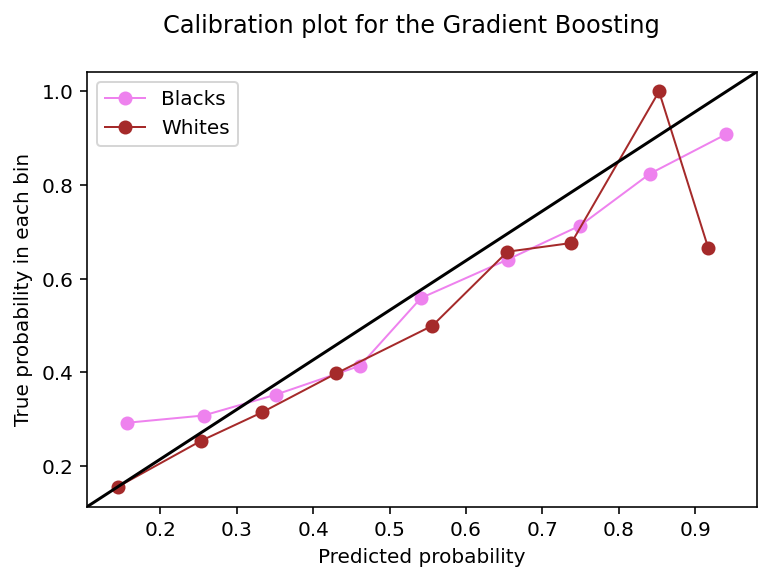

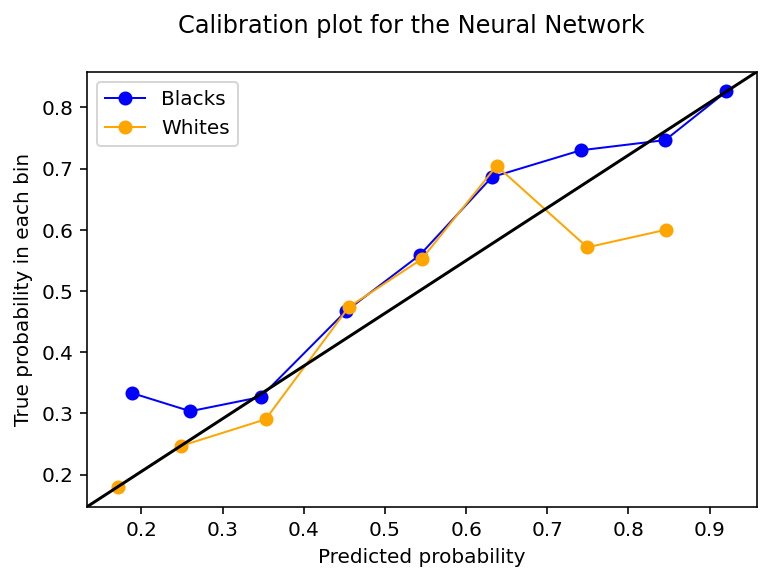

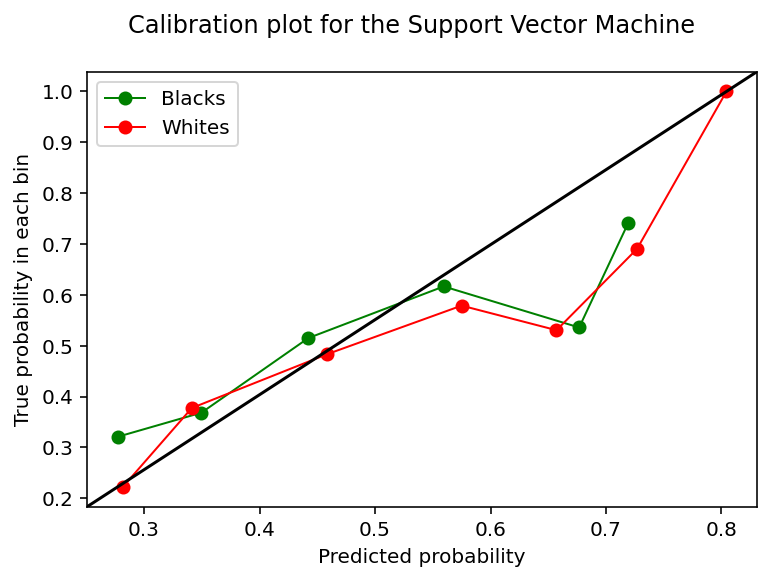

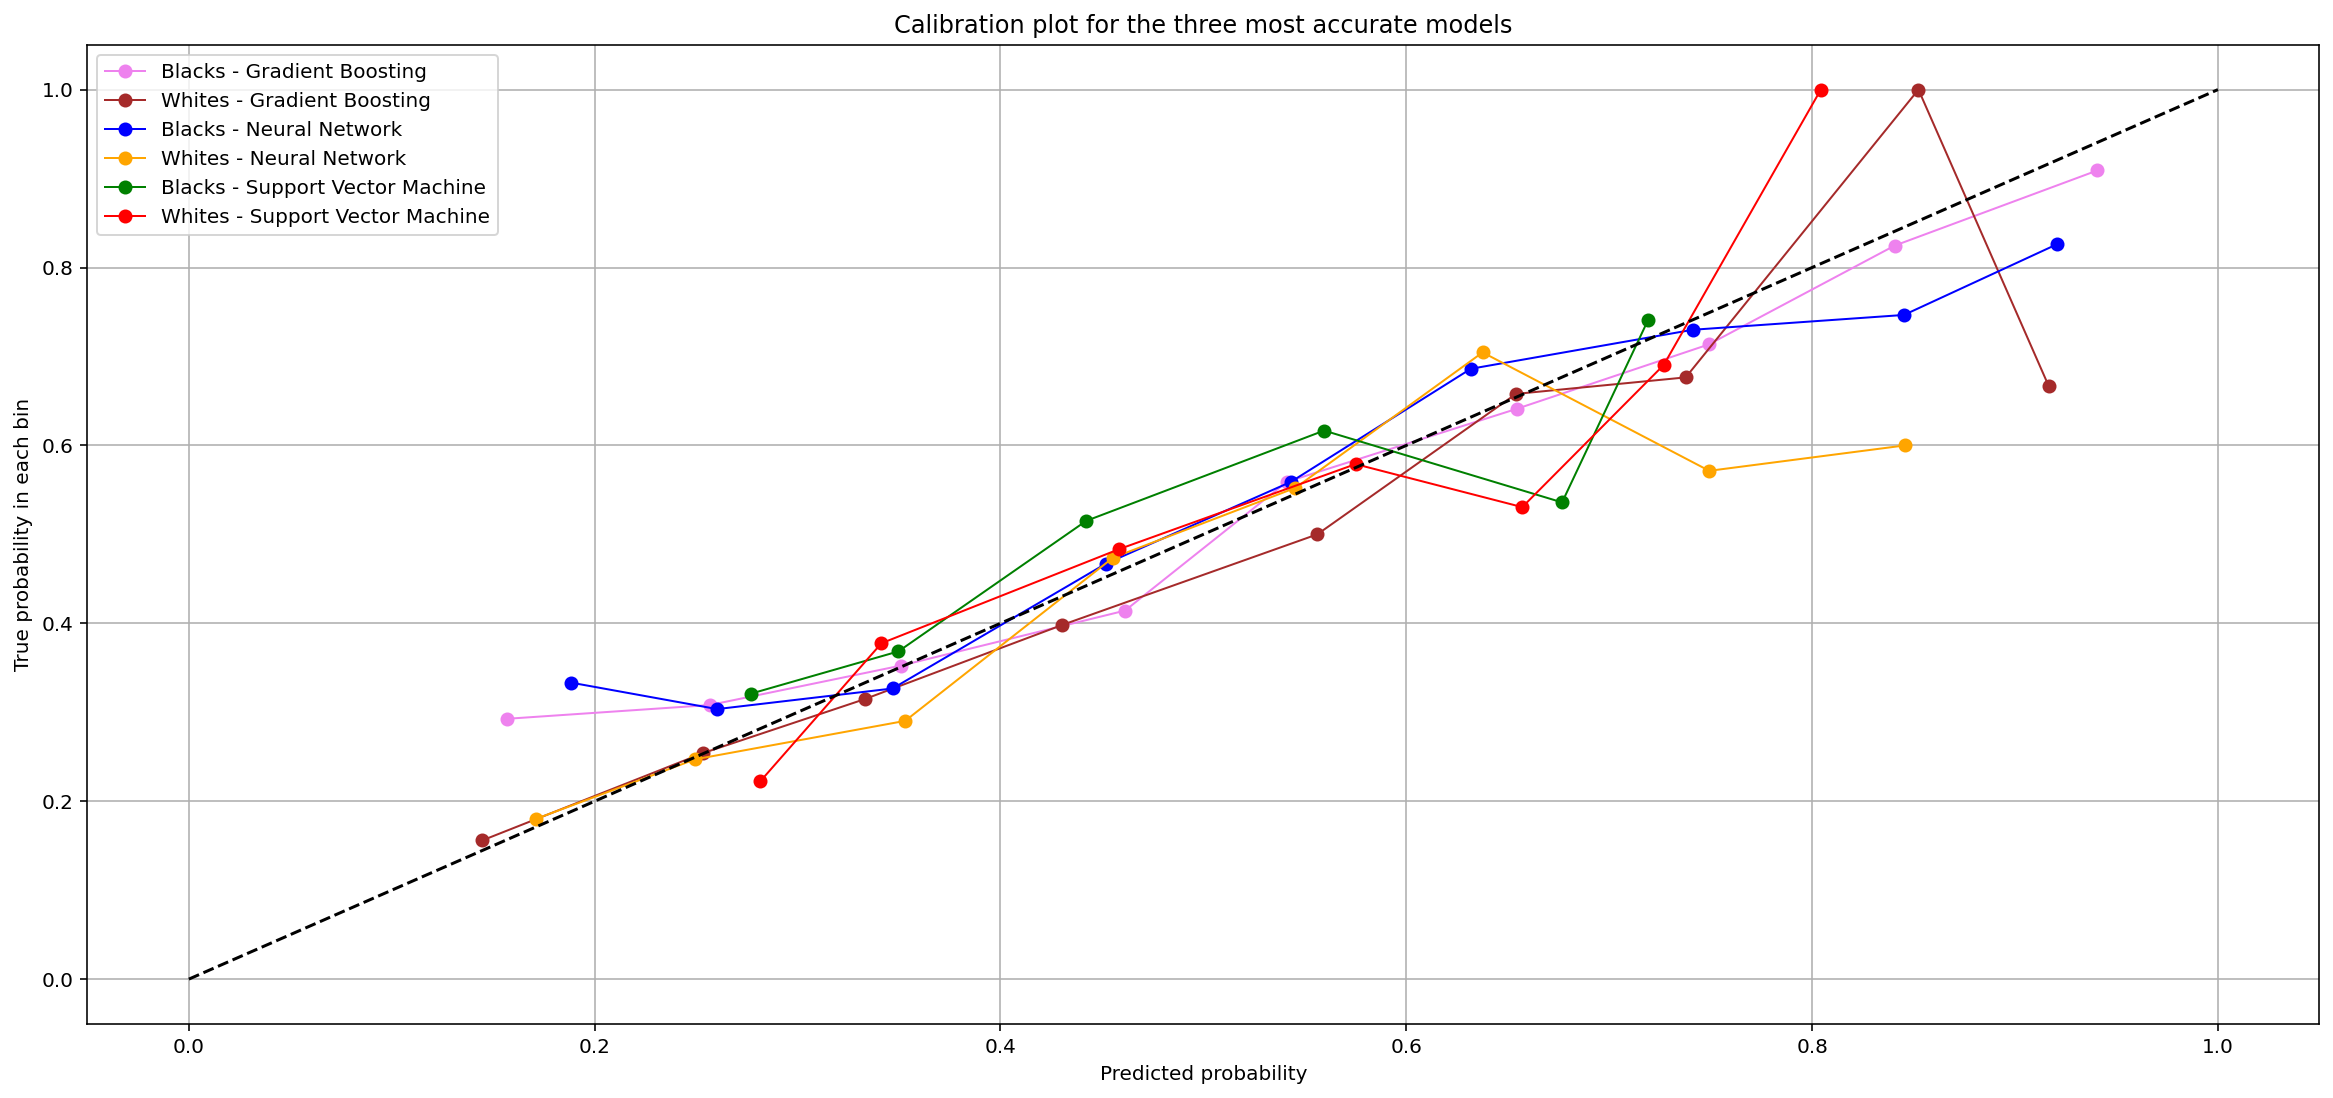

In [15]:
# Calibration curve analysis
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# plotting calibration curve separately for each of the three most accurate models
for name, (model, color_b, color_w) in models.items():
    scores = model.predict_proba(X_test_b)
    prob_true_b, prob_pred_b = calibration_curve(y_test_b, scores[:,1], n_bins=10)
    scores = model.predict_proba(X_test_w)
    prob_true_w, prob_pred_w = calibration_curve(y_test_w, scores[:,1], n_bins=10)
    
    fig, ax = plt.subplots()
    # only this line is calibration curves
    plt.plot(prob_pred_b, prob_true_b, marker='o', linewidth=1, label='Blacks', color = color_b)
    plt.plot(prob_pred_w, prob_true_w, marker='o', linewidth=1, label='Whites', color = color_w)
    fig.suptitle('Calibration plot for the ' + name)

    # reference line, legends, and axis labels
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.legend()
plt.show()


# plotting calibration curve for all of the three most accurate models
plt.figure(figsize=(20, 9))
for name, (model, color_b, color_w) in models.items():
    scores = model.predict_proba(X_test_b)
    prob_true_b, prob_pred_b = calibration_curve(y_test_b, scores[:,1], n_bins=10)
    scores = model.predict_proba(X_test_w)
    prob_true_w, prob_pred_w = calibration_curve(y_test_w, scores[:,1], n_bins=10)

    # only this line is calibration curves
    plt.plot(prob_pred_b, prob_true_b, marker='o', linewidth=1, label='Blacks - '+ name, color = color_b)
    plt.plot(prob_pred_w, prob_true_w, marker='o', linewidth=1, label='Whites - '+ name, color = color_w)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Calibration plot for the three most accurate models')
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.grid(True)
plt.legend()  
plt.show()

What we can infer from these graphs is as follows:

- **Gradient Boosting:**
  the curve for **Gradient Boosting** shows that both Black and White defendants' predicted probabilities closely follow the reference line, which means the predicted probabilities are a good representation of the true values. However, at the very end we can see some divergence which indicates imperfections in calibration.
- **Neural Network:**
  the **Neural Network** calibration curve for Black defendants appears to be slightly better calibrated in the middle than for White defendants. The White group's curve deviates more from the reference line. This may suggest that the **Neural Network**'s predictions for White defendants could be less reliable in terms of showing the true likelihood of recidivism.
- **Support Vector Machine:**
  for the **Support Vector Machine**, there is divergence between the calibration for Black and White defendants. The calibration for White defendants deviates more from the reference line. This suggests potential differences in how the **SVM** model's predicted probabilities align with the actual values.
- we depend on the idea that the model that is equally calibrated for both racial groups across all probabilities is considered as fairer. Conflicts between the groups suggest that the model may not be treating each group with the same level of accuracy.



In [16]:
# comparison between the COMPAS classifier and the three most accurate models

# we need to define the COMPAS classifier
threshold = 5.5
df['score_text_pred'] = df.score_text != 'Low'
df['decile_score_pred'] = (df['decile_score'] >= threshold)
df['two_year_recid'] = (df['two_year_recid'] == 1)
y_test_bool = (y_test ==1)
y_svm = (y_svm_pred == 1)
y_nn = (y_nn_pred == 1)
y_gb = (y_gb_pred == 1)

# print(y_test.shape)
# print(df['two_year_recid'].shape)

# performance analysis
print("COMPAS classifier - based on decile_score:\n")
print_metrics(df['two_year_recid'], df['decile_score_pred'])
print("COMPAS classifier - based on score_text:  \n")
print_metrics(df['two_year_recid'], df['score_text_pred'])
print("Support Vector Machine:                   \n")
print_metrics(y_test_bool, y_svm)
print("Neural Network:                           \n")
print_metrics(y_test_bool, y_nn)
print("Gradient Boosting:                        \n")
print_metrics(y_test_bool, y_gb)

COMPAS classifier - based on decile_score:



actual,False,True
guessed,,
False,2647,716
True,1356,1453



Accuracy:  0.6642903434867142
PPV:  0.5172659309362763
FPR:  0.33874594054459156
FNR:  0.3301060396496081

COMPAS classifier - based on score_text:  



actual,False,True
guessed,,
False,2345,1018
True,1076,1733



Accuracy:  0.6607258587167855
PPV:  0.6169455322178711
FPR:  0.31452791581408945
FNR:  0.37004725554343876

Support Vector Machine:                   



actual,False,True
guessed,,
False,751,264
True,368,470



Accuracy:  0.6589314624932542
PPV:  0.5608591885441527
FPR:  0.3288650580875782
FNR:  0.35967302452316074

Neural Network:                           



actual,False,True
guessed,,
False,780,235
True,388,450



Accuracy:  0.6637884511602806
PPV:  0.5369928400954654
FPR:  0.3321917808219178
FNR:  0.34306569343065696

Gradient Boosting:                        



actual,False,True
guessed,,
False,737,278
True,341,497



Accuracy:  0.6659471127900701
PPV:  0.5930787589498807
FPR:  0.3163265306122449
FNR:  0.35870967741935483



### Fairness Analysis

Now we attempt to analyze fairness through comparing the performance of the COMPAS and how different classifiers perform in predicting recidivism across racial lines. We generate predictions using several classifiers, including **COMPAS** \(as a baseline\), **Neural Network**, **Gradient Boosting**, and **Support Vector Machine** models. For each model, we calculate predictions for both White and Black defendants separately. We delve into the performance of each classifier by calculating essential metrics. By analyzing these metrics for White and Black defendants we aim to infer whether there are significant differences/injustice in model performance between these groups. 



In [17]:
# fairness analysis

# Calculate predictions for COMPAS classifier
compas_white_p = df[df.race == 'Caucasian'].guessed_recid
compas_black_p = df[df.race == 'African-American'].guessed_recid

# Calculate predictions for Neural Network classifier
nn_white_p = clf_nn.predict(X_test_w) == 1
nn_black_p = clf_nn.predict(X_test_b) == 1

# Calculate predictions for Gradient Boosting classifier
gb_white_p = clf_gb.predict(X_test_w) == 1
gb_black_p = clf_gb.predict(X_test_b) == 1

# Calculate predictions for Support Vector Machines classifier
svm_white_p = clf_svm.predict(X_test_w) == 1
svm_black_p = clf_svm.predict(X_test_b) == 1

y_test_w = (y_test_w == 1)
y_test_b = (y_test_b == 1)


def calculate_metrics(cm):
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]  
    
    accuracy = (TN+TP)/(TN+TP+FN+FP)
    ppv = TP / (TP + FP)
    fpr = FP / (FP + TN)
    fnr = FN / (FN + TP)
    
    return accuracy, ppv, fpr, fnr

def generate_metrics_table(guessed_w, actual_w, guessed_b, actual_b):
    cm_w = pd.crosstab(guessed_w, actual_w, rownames=['guessed'], colnames=['actual'])
    cm_b = pd.crosstab(guessed_b, actual_b, rownames=['guessed'], colnames=['actual'])

    accuracy_w, ppv_w, fpr_w, fnr_w = calculate_metrics(cm_w)
    accuracy_b, ppv_b, fpr_b, fnr_b = calculate_metrics(cm_b)


    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'PPV', 'FPR', 'FNR'],
        'White': [accuracy_w, ppv_w, fpr_w, fnr_w],
        'Black': [accuracy_b, ppv_b, fpr_b, fnr_b],
    })
    metrics_df.set_index('Metric', inplace=True)

    return metrics_df

def generate_cm_table(guessed_w, actual_w, guessed_b, actual_b):
    cm_w = pd.crosstab(guessed_w, actual_w, rownames=['guessed'], colnames=['actual'])
    cm_b = pd.crosstab(guessed_b, actual_b, rownames=['guessed'], colnames=['actual'])
    
    return pd.concat([pd.DataFrame(cm_w), pd.DataFrame(cm_b)], axis=1, keys=['White Confusion Matrix', 'Black Confusion Matrix'])

print("Metrics Table -- COMPAS classifier:")
display(generate_metrics_table(compas_white_p, df[df.race == 'Caucasian'].actual_recid, 
                                      compas_black_p, df[df.race == 'African-American'].actual_recid))
print("\nConfusion Matrix Table -- COMPAS classifier:")
display(generate_cm_table(compas_white_p, df[df.race == 'Caucasian'].actual_recid, 
                                      compas_black_p, df[df.race == 'African-American'].actual_recid))

print("Metrics Table -- Neural Network:")
display(generate_metrics_table(nn_white_p, y_test_w, nn_black_p, y_test_b))
print("\nConfusion Matrix Table -- Neural Network:")
display(generate_cm_table(nn_white_p, y_test_w, nn_black_p, y_test_b))


print("Metrics Table -- Gradient Boosting:")
display(generate_metrics_table(gb_white_p, y_test_w, gb_black_p, y_test_b))
print("\nConfusion Matrix Table -- Gradient Boosting:")
display(generate_cm_table(gb_white_p, y_test_w, gb_black_p, y_test_b))


print("Metrics Table -- Support Vector Machines:")
display(generate_metrics_table(svm_white_p, y_test_w, svm_black_p, y_test_b))
print("\nConfusion Matrix Table -- Support Vector Machines:")
display(generate_cm_table(svm_white_p, y_test_w, svm_black_p, y_test_b))


Metrics Table -- COMPAS classifier:


,White,Black
Metric,,
Accuracy,0.671897,0.649134
PPV,0.594828,0.649535
FPR,0.220141,0.423382
FNR,0.496350,0.284768



Confusion Matrix Table -- COMPAS classifier:


White Confusion Matrix       Black Confusion Matrix      
actual                   False True                   False True 
guessed                                                          
False                      999   408                    873   473
True                       282   414                    641  1188

Metrics Table -- Neural Network:


,White,Black
Metric,,
Accuracy,0.673534,0.655824
PPV,0.605634,0.669355
FPR,0.141772,0.358862
FNR,0.635593,0.330645



Confusion Matrix Table -- Neural Network:


White Confusion Matrix       Black Confusion Matrix      
actual                   False True                   False True 
guessed                                                          
False                      339   150                    293   164
True                        56    86                    164   332

Metrics Table -- Gradient Boosting:


,White,Black
Metric,,
Accuracy,0.673534,0.663169
PPV,0.585227,0.664783
FPR,0.184810,0.389497
FNR,0.563559,0.288306



Confusion Matrix Table -- Gradient Boosting:


White Confusion Matrix       Black Confusion Matrix      
actual                   False True                   False True 
guessed                                                          
False                      322   133                    279   143
True                        73   103                    178   353

Metrics Table -- Support Vector Machines:


,White,Black
Metric,,
Accuracy,0.662441,0.651626
PPV,0.565714,0.663347
FPR,0.192405,0.369803
FNR,0.580508,0.328629



Confusion Matrix Table -- Support Vector Machines:


White Confusion Matrix       Black Confusion Matrix      
actual                   False True                   False True 
guessed                                                          
False                      319   137                    288   163
True                        76    99                    169   333

<span style='font-size:medium'>The </span><span style='font-size:medium'>**metrics tables**</span><span style='font-size:medium'> present the accuracy, precision/</span><span style='font-size:medium'>**PPV**</span><span style='font-size:medium'>, false positive rate \(</span><span style='font-size:medium'>**FPR**</span><span style='font-size:medium'>\), and false negative rate \(</span><span style='font-size:medium'>**FNR**</span><span style='font-size:medium'>\) split by race \(White and Black defendants\).</span>

- <span style='font-size:medium'>in terms of </span><span style='font-size:medium'>**accuracy, Neural Networks**</span><span style='font-size:medium'> appears to give the best accuracy scores for both White and Black groups that is very close to those of </span><span style='font-size:medium'>**COMPAS**</span><span style='font-size:medium'>'s. This accuracy score is higher for White group than that of Black group in all classifiers, indicating that the classifier is more correct in its predictions for the White group. The </span><span style='font-size:medium'>**NNs**</span><span style='font-size:medium'> have the least difference in the two scores.</span>
- <span style='font-size:medium'>in terms of </span><span style='font-size:medium'>**PPV**</span><span style='font-size:medium'>, </span><span style='font-size:medium'>**PPV**</span><span style='font-size:medium'> measures the proportion of positive identifications that were actually correct. </span><span style='font-size:medium'>**Neural Networks, GBs**</span><span style='font-size:medium'> and </span><span style='font-size:medium'>**SVMs**</span><span style='font-size:medium'> and even </span><span style='font-size:medium'>**COMPAS**</span><span style='font-size:medium'> have higher </span><span style='font-size:medium'>**PPV**</span><span style='font-size:medium'> for Black defendants than for White ones. This indicates that all classifiers' predictions are more often correct when they predict a positive score for Black individuals. In other words, when the classifiers predict that a Black person will recidivate, it is more likely to be a correct prediction than when it makes the same prediction for a White one. </span><span style='font-size:medium'>**COMPAS**</span><span style='font-size:medium'> has the least difference between the 2 score values.</span>
- <span style='font-size:medium'>**FPR**</span><span style='font-size:medium'> shows how many non recidivist individuals are incorrectly predicted to recidivate.</span><span style='font-size:medium'>**GB**</span><span style='font-size:medium'> dominates with the highest values for both groups, but for all classifiers the Black group's score is higher. This indicates that Black individuals who do not recidivate are much more likely to be wrongly classified as potential recidivists compared to White ones. </span><span style='font-size:medium'>**GB** </span><span style='font-size:medium'>has the least gap between the 2 scores.</span>
- <span style='font-size:medium'>**FNR** </span><span style='font-size:medium'>indicates the proportion of actual positive cases that were missed by the classifier. All classifiers have lower FNR for Black group than for White one, this means that the classifiers are more likely to miss an actual case of recidivism in the White population than in the Black population.</span>



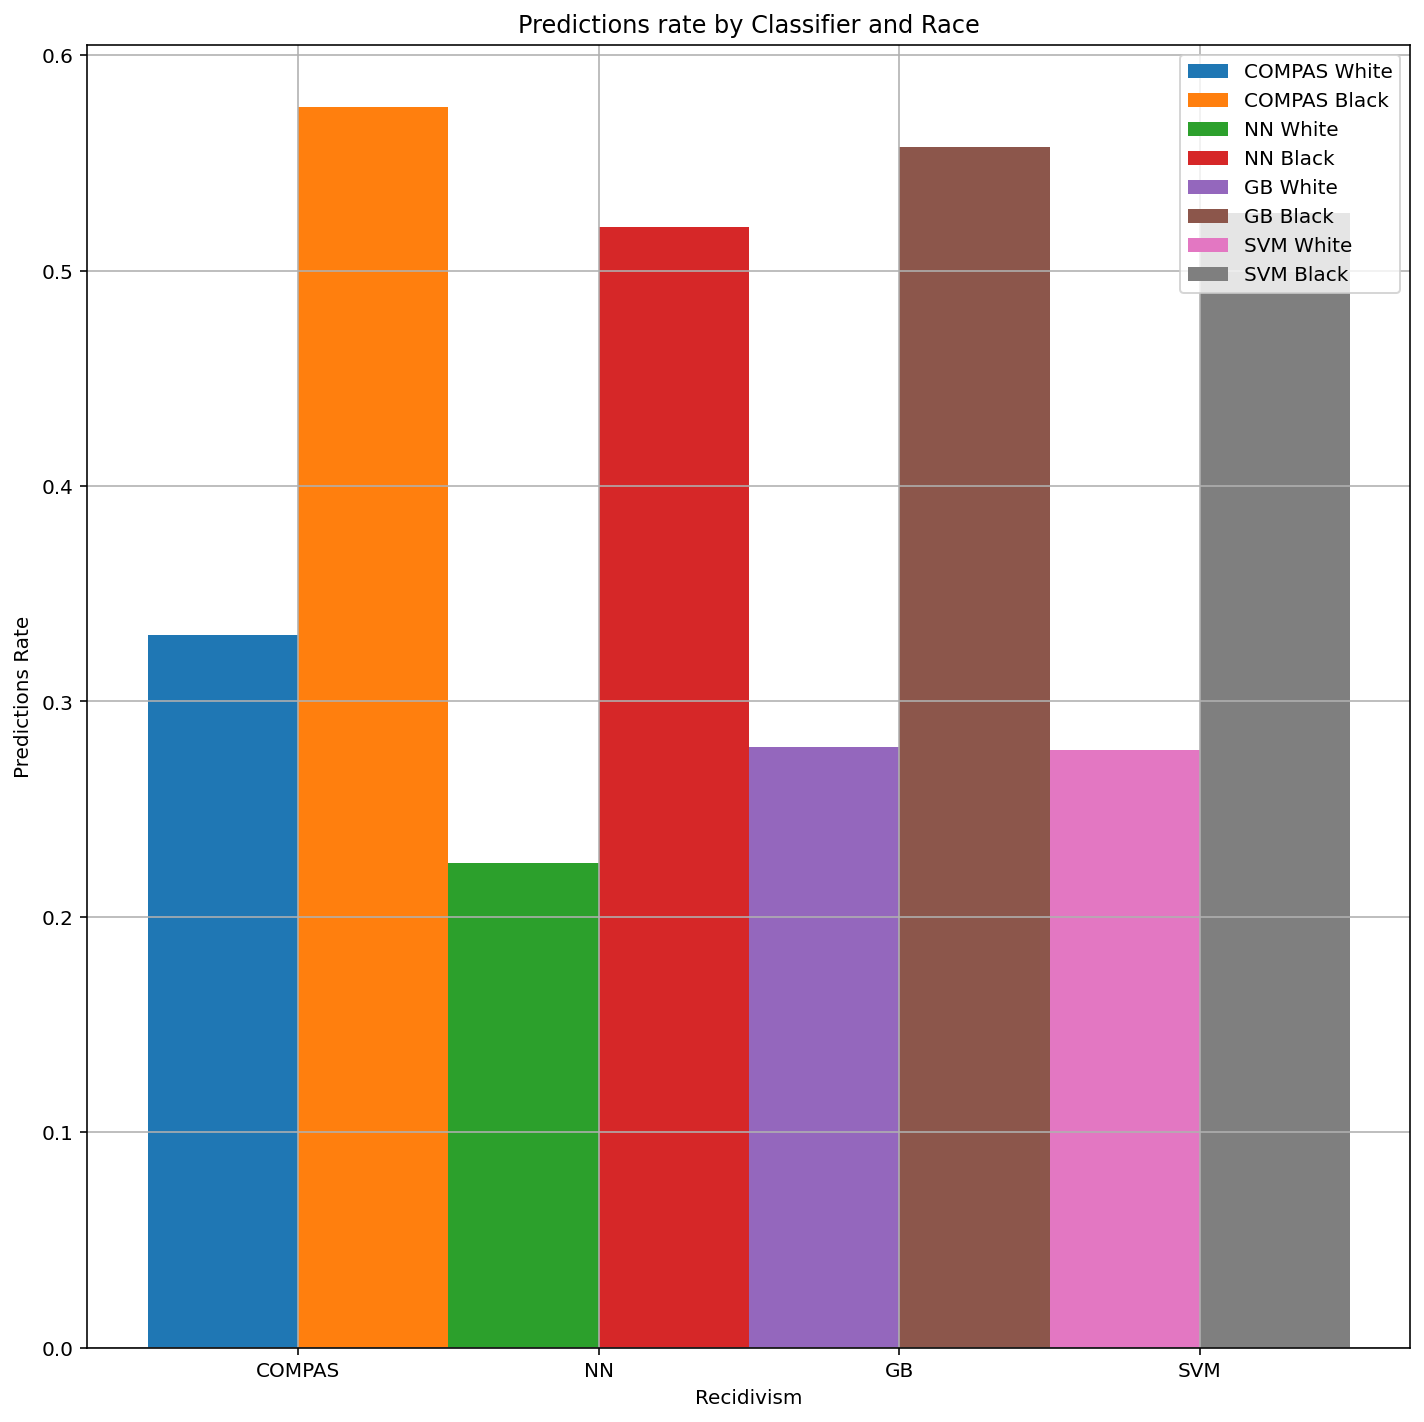

In [18]:
compas_white_pred = [compas_white_p.sum() / compas_white_p.size]
compas_black_pred = [compas_black_p.sum() / compas_black_p.size]
nn_white_pred = [nn_white_p.sum() / nn_white_p.size]
nn_black_pred = [nn_black_p.sum() / nn_black_p.size]
gb_white_pred = [gb_white_p.sum() / gb_white_p.size]
gb_black_pred = [gb_black_p.sum() / gb_black_p.size]
svm_white_pred = [svm_white_p.sum() / svm_white_p.size]
svm_black_pred = [svm_black_p.sum() / svm_black_p.size]

# Plot histogram
plt.figure(figsize=(10, 10))
bar_width = 0.1
index = 0

data_list = [[compas_white_pred, 'COMPAS White'], 
             [compas_black_pred, 'COMPAS Black'], 
             [nn_white_pred, 'NN White'], 
             [nn_black_pred, 'NN Black'], 
             [gb_white_pred, 'GB White'],
             [gb_black_pred, 'GB Black'],
             [svm_white_pred, 'SVM White'],
             [svm_black_pred, 'SVM Black']]

for pred, p_label in data_list:
    plt.bar(index * bar_width, pred, bar_width, label = p_label)
    index += 1

plt.xlabel('Recidivism')
plt.ylabel('Predictions Rate')
plt.title('Predictions rate by Classifier and Race')
plt.xticks([i * bar_width for i in [0.5, 2.5, 4.5, 6.5]], ['COMPAS', 'NN', 'GB', 'SVM'])
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

<span style='font-size:medium'>In this part we present a bar chart to illustrate the proportion of defendants that each classifier predicted would recidivate. The bar chart compares the prediction rates of recidivism across four different classifiers—</span><span style='font-size:medium'>**COMPAS**</span><span style='font-size:medium'>, Neural Network \(</span><span style='font-size:medium'>**NN**</span><span style='font-size:medium'>\), Gradient Boosting \(</span><span style='font-size:medium'>**GB**</span><span style='font-size:medium'>\), and Support Vector Machine \(</span><span style='font-size:medium'>**SVM**</span><span style='font-size:medium'>\) for White and Black defendants. What we can infer is the following:</span>

- <span style='font-size:medium'>**COMPAS:**</span><span style='font-size:medium'> There is a difference in prediction rates between White and Black defendants. The prediction rate for Black defendants is higher than for White defendants. This suggests that COMPAS may predict recidivism for Black defendants at a higher rate, which could indicate racial bias within the tool.</span>
- <span style='font-size:medium'>**NN**</span><span style='font-size:medium'>: the prediction rate for Black defendants is also higher compared to White defendants. There might be a potential bias in the </span><span style='font-size:medium'>**NN**</span><span style='font-size:medium'> models. Same thing goes for </span><span style='font-size:medium'>**GB**</span><span style='font-size:medium'> and </span><span style='font-size:medium'>**SVM**</span><span style='font-size:medium'>.</span>
- <span style='font-size:medium'>the results might suggest that all classifiers tend to predict higher rates of recidivism for Black defendants compared to White defendants. </span>



# Fair classifier approaches
We can distinguish three types of approaches to constructing a fair classifier. The first one is to perform pre-processing, which involves modifying the dataset before the training phase. The second one is named in-processing and involves adding a fair notion to the learning procedure. The third one is denoted as post-processing, and it modifies model predictions to achieve fairness. In our project, we consider two of the above-described approaches: pre-processing and post-processing.  

For the pre-processing, the data points are represented as different points such that we would achieve three notions. We consider the new representation as a probabilistic mapping to a set of prototypes. The first of the three notions is that the data points should be close to the original points. Second, it should satisfy statistical parity, which is the probability of the random protected group element (in our case, the race) being mapped to the same prototype as the random element from the unprotected group should be equal. The third notion is to have a guarantee that the prediction is accurate.  

For the post-processing, the method adjusts the predicted probabilities to satisfy the equalized odds criterion while preserving calibration. Equalized odds means that the true positive rates and false positive rates are equal across different demographic groups (in our case, racial groups).

# Fair classifier
## Using preprocessing technique to approach fairness issue
In following code the aif360 preprocessing technique is used. Before teaching the classifier we transform the data wich affects both features and labels.
we use Learning Fair Representations (LFR), which is a pre-processing technique designed to learn a fair transformation of the features. We start by loading the dataset preprocessed with race as a sensitive attribute i.e, 'race' as a key attribute that may influence the outcome. Here, priviliged and unprivileged groups are defined based on the attribute 'race'. We then apply LFR that mitigates bias by finding a fair representation of the data. The model is fitted on the training data with a specified number of iterations and function evaluations.

The classification reports and fairness metrics for both **SVM** and **LR** models provide insights into the efficacy of predictions after preprocessing, here is our analysis for that:

at each step/iteration, the loss indicates the performance of LFR.

The goal is to minimize this loss while balancing the three aspects: reconstruction error \(**L\_x**\), prediction error \(**L\_y**\), and fairness \(**L\_z**\)

**L\_x** : relates to the reconstruction fidelity of the transformed features. We want the transformed features to retain as much useful information as possible.

**L\_y** : the predictive accuracy of the outcome, which should remain high even after transformation for fairness.

**L\_z** : represents the fairness constraint, aiming for a lower value, which indicates a reduction in bias.


In [4]:
# now, we use pre-processing approach for the data before training phase -- paper in question: https://proceedings.mlr.press/v28/zemel13.html
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.algorithms.preprocessing.lfr import LFR

#logistic regression and SVM classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

#accuracy and classification report metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#fairness metrics from AIF360
from aif360.sklearn.metrics import equal_opportunity_difference, statistical_parity_difference, average_odds_difference
import pandas as pd
from prettytable import PrettyTable



#load the preprocessed data with race as a sensitive attribute
dataset = load_preproc_data_compas(['race'])
## Split the dataset
train, test = dataset.split([0.7], shuffle=True, seed=145)

#normalize features by removing the mean and scaling to unit variance
scale_orig = StandardScaler()
#we fit the scaler on the training features and transform them to a standardized scale
train.features = scale_orig.fit_transform(train.features)
#we transfrom testing features to same scale based on the scaler fitted to the training data
test.features = scale_orig.transform(test.features)

#privileged and unprivileged groups based on attrivb 'race'
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

#Learning Fair Representations (LFR) model from AIF360
# k  - Number of prototypes
# Ax - Input recontruction quality term weight.
# Ay - Output prediction error
# Az - Fairness constraint term weight
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=3, Ax=0.1, Ay=0.2, Az=2.0,
         verbose=0,
         seed=748
        )
#we fit the LFR model to training data, specify maximum iterations and function evaluations
#this will optimize the representation of the data to mitigate bias with respect to the race
TR = TR.fit(train, maxiter=15000, maxfun=15000)

train_transformed = TR.transform(train)
test_transformed = TR.transform(test)



pip install 'aif360[OptimalTransport]'
C:\Users\ilyin\AppData\Local\Programs\Python\Python310\lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:163: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfcutQ['sex'] = dfcutQ['sex'].replace({'Female': 1.0, 'Male': 0.0})


### Comparing different models
In following section we compare different classificators measuring their accuracy and fairness scores.

Each model is tested both on transformed and not transformed data, results are compared.

To evaluate how the transformation affects each model, metrics such as **accuracy loss** and **fairness gain** are introduced. Both metrics are relative to the initial model.

* **Accuracy loss** denotes how much accuracy compared to the accuracy of untransformed model is lost measuring from level 0.5 (i.e. if accuracy dropped to 0.5, the accuracy loss score is 1.0)
* **Fairness gain** denotes how much have the certain fairness metric improved


In [56]:
models_compare_EOD = []
models_compare_SPD = []
models_compare_AOD = []

def try_model(mdl):
    print("\n\n ======== Trying model", str(mdl), " ========")
    mdl.fit(train_transformed.features, train_transformed.labels.ravel())
    # Predict on transformed test data
    y_pred = mdl.predict(test_transformed.features)

    # Print classification report: it includes key metrics like precision, recall, f1-score, and support
    #print(classification_report(test.labels, y_pred))

    truth_s = pd.Series(test.labels.flatten())
    y_pred_s = pd.Series(y_pred.flatten())

    ACC = accuracy_score(truth_s, y_pred_s)
    EOD = equal_opportunity_difference(truth_s, y_pred_s)
    SPD = statistical_parity_difference(truth_s, y_pred_s)
    AOD = average_odds_difference(truth_s, y_pred_s)
    
    mdl.fit(train.features, train.labels.ravel())
    # Predict on transformed test data
    y_pred = mdl.predict(test.features)

    # Print classification report: it includes key metrics like precision, recall, f1-score, and support
    #print(classification_report(test.labels, y_pred))

    truth_s = pd.Series(test.labels.flatten())
    y_pred_s = pd.Series(y_pred.flatten())

    ACC_unfair = accuracy_score(truth_s, y_pred_s)
    EOD_unfair = equal_opportunity_difference(truth_s, y_pred_s)
    SPD_unfair = statistical_parity_difference(truth_s, y_pred_s)
    AOD_unfair = average_odds_difference(truth_s, y_pred_s)

    ACC_lost = -(ACC_unfair - ACC) / (ACC_unfair - 0.5)
    EOD_gain = (abs(EOD_unfair) - abs(EOD)) / abs(EOD_unfair)
    SPD_gain = (abs(SPD_unfair) - abs(SPD)) / abs(SPD_unfair)
    AOD_gain = (abs(AOD_unfair) - abs(AOD)) / abs(AOD_unfair)
    avg_fair_gain = (EOD_gain + SPD_gain + AOD_gain) / 3

    table = PrettyTable(["Metric", "Value Unfair", "Value Fair", "Normalized Diff"])
    table.add_row(["Accuracy", "{:.2f}".format(ACC_unfair), "{:.2f}".format(ACC), "{:.2f}".format(ACC_lost)])
    table.add_row(["Equal Opportunity Difference", "{:.2f}".format(EOD_unfair), "{:.2f}".format(EOD), "{:.2f}".format(EOD_gain)])
    table.add_row(["Statistical Parity Difference", "{:.2f}".format(SPD_unfair), "{:.2f}".format(SPD), "{:.2f}".format(SPD_gain)])
    table.add_row(["Average Odds Difference", "{:.2f}".format(AOD_unfair), "{:.2f}".format(AOD), "{:.2f}".format(AOD_gain)])
    print(table)
    print("Accuracy lost: ", "{:.2f}".format(-ACC_lost))
    print("Average Fairness Gain: ", "{:.2f}".format(avg_fair_gain), "/ 1.0")
    
    model_stats = [
        str(mdl), 
        ACC_unfair, 
        abs(EOD_unfair),
        ACC, 
        abs(EOD)]
    models_compare_EOD.append(model_stats)
    model_stats = [
        str(mdl), 
        ACC_unfair, 
        abs(SPD_unfair),
        ACC, 
        abs(SPD)]
    models_compare_SPD.append(model_stats)
    model_stats = [
        str(mdl), 
        ACC_unfair, 
        (AOD_unfair),
        ACC, 
        (AOD)]
    models_compare_AOD.append(model_stats)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
    
# Trying different models on modified data
try_model(SVC(kernel='linear'))
try_model(LogisticRegression())
try_model(KNeighborsClassifier(n_neighbors=15))
try_model(DecisionTreeClassifier())
try_model(LogisticRegression(solver='lbfgs'))
try_model(SVC(probability=True))
try_model(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, solver = 'sgd'))
try_model(GradientBoostingClassifier())



 ======== Trying model SVC(kernel='linear')  ========
+-------------------------------+--------------+------------+-----------------+
|             Metric            | Value Unfair | Value Fair | Normalized Diff |
+-------------------------------+--------------+------------+-----------------+
|            Accuracy           |     0.63     |    0.59    |      -0.31      |
|  Equal Opportunity Difference |     0.66     |    0.44    |       0.34      |
| Statistical Parity Difference |     0.52     |    0.35    |       0.33      |
|    Average Odds Difference    |     0.03     |   -0.15    |      -4.02      |
+-------------------------------+--------------+------------+-----------------+
Accuracy lost:  0.31
Average Fairness Gain:  -1.12 / 1.0


 ======== Trying model LogisticRegression()  ========
+-------------------------------+--------------+------------+-----------------+
|             Metric            | Value Unfair | Value Fair | Normalized Diff |
+------------------------------

In this section of our project, we evaluate the performance and fairness of different machine learning models using the transformed data that has been pre-processed. The goal is to understand how different models perform on the fairness metrics after transformation, in comparison to their performance before transformation. This allows us to critically analyze the efficiancy  of the pre-processing bias mitigation technique.
The difference metrics we used to evaluate and comapre include:
1.   **Accuracy**: to measure the correctness of the classifiers, it represents the proportion of true results (both true positives and true negatives) among the total number of cases examined

2.   Equal Opportunity Difference (**EOD**):  the difference in true positive rates between unprivileged and privileged groups. Aims to evaluate differences in true positive rates between racial groups, seeking parity.

3.   Statistical Parity Difference (**SPD**):  the difference in positive prediction rates between unprivileged and privileged groups, to assess the balance in positive prediction rates, reflecting non-discrimination in predictions.

4.   Average Odds Difference (**AOD**): average of difference in false positive rates and true positive rates between unprivileged and privileged groups, to illustrate fairness across both positive and negative outcomes.

Additionally, '**Accuracy Lost**' measures how much the accuracy of a model decreases when trying to make it fairer.
From what we can see, the **Gradient Bossing Classifier** has the highest Accuracy Lost value = 0.41 while the lowest one is achieved by **KNeighborsClassifier** with value 0.28. This shows that Gradient Boosting Classifier while perhaps being an accurate model, it still loses more accuracy when fairness constraints are applied compared to the KNeighbors Classifier. So, the KNeighborsClassifier is less affected by the fairness adjustments we did, suggesting that it may be more balanced across groups or  that it adapts better to the fairness constraints with a smaller effect on accuracy.

Moreover, the **Average Fairness Gain** value shows how much the model was affected by the fairness adjustments.
take for example Gradient Boosting Classifier the Average Fairness Gain is -0.10 meaning the model had a very small decrease in fairness, implying it was only slightly affected by the fairness constraints.While on the other hans, SVC (kernel='linear')had an Average Fairness Gain of -1.12 suggesting that this model experienced the largest decrease in fairness out of all models we tried.  So, in this term Gradient Boosting Classifier and SVC demonstrated the smallest reduction in fairness according to the fairness gain metric.



### Visual representation of the trade-off between fairness and accuracy

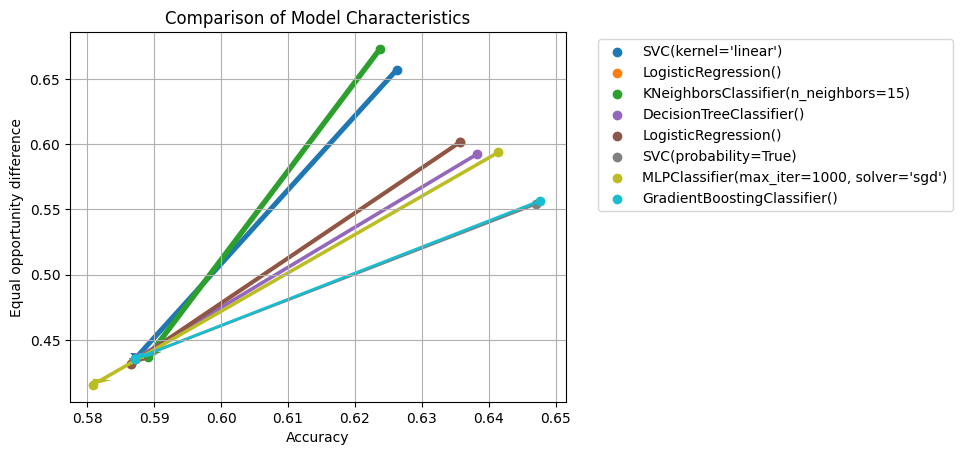

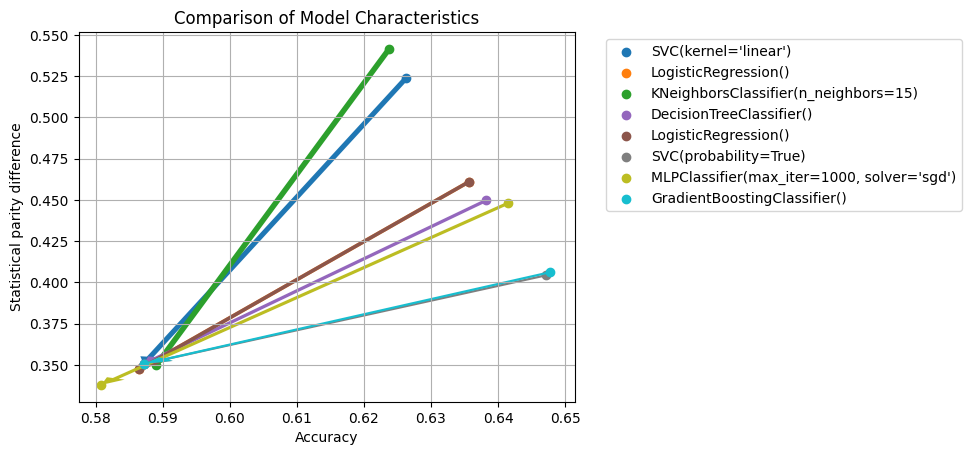

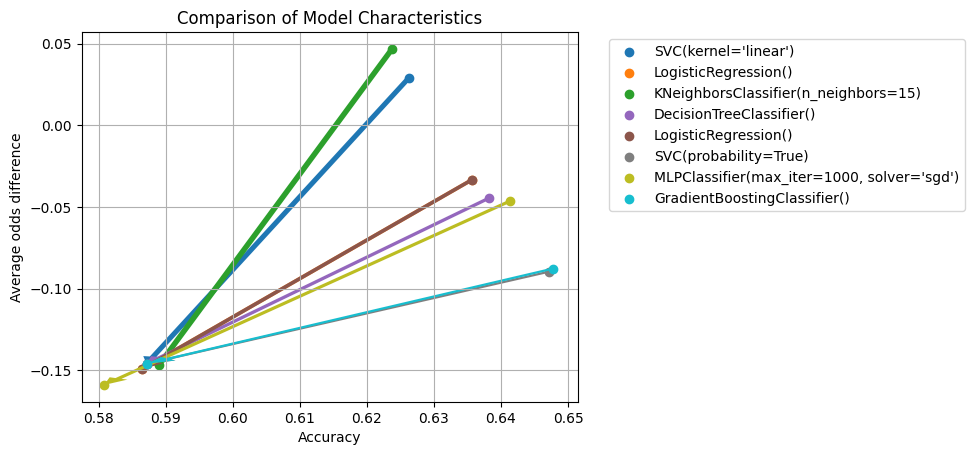

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(models_compare, ylabel):
    # Define a color palette
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(models_compare)))

    # Create a scatter plot
    for i, model in enumerate(models_compare):
        color = color_palette[i]
        plt.scatter(model[1], model[2], label=model[0], color=color)
        plt.scatter(model[3], model[4], color=color)

        # Add arrows
        plt.arrow(model[1], model[2], model[3] - model[1], model[4] - model[2], 
                  shape='full', color=color, lw=0.01, length_includes_head=True, 
                  head_width=0.003)
        #plt.plot(model[1], model[2], model[3], model[4], 
        #          color=color)

    # plt.xlim(0, 1)
    # plt.ylim(0, 1)    

    # Set labels and title
    plt.xlabel('Accuracy')
    plt.ylabel(ylabel)
    plt.title('Comparison of Model Characteristics')

    # Move legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.grid(True)
    plt.show()
    
plot_comparison(models_compare_EOD, "Equal opportunity difference")
plot_comparison(models_compare_SPD, "Statistical parity difference")
plot_comparison(models_compare_AOD, "Average odds difference")

It can be seen that along with improving fairness characteristics the accuracy is decreased.

## Post-processing

Another approach to fairness is postprocessing, where we apply changes to already fitted models.
First we load dataset and split it into train, validation and test subsets

In [6]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

#load the preprocessed data with race as a sensitive attribute
dataset_orig = load_preproc_data_compas(['race'])

## Split the dataset
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.6], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#privileged and unprivileged groups based on attrivb 'race'
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

C:\Users\ilyin\AppData\Local\Programs\Python\Python310\lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:163: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfcutQ['sex'] = dfcutQ['sex'].replace({'Female': 1.0, 'Male': 0.0})


Here we display the metrics of original dataset once to compare with them later

In [10]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.129317


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.138724


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.134756


### Training the model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import numpy as np

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_valid.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

Results of classifier before post-processing

In [12]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.12019626838037945
Difference in GFNR between unprivileged and privileged groups
0.10879682253978029


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.1285476279108964
Difference in GFNR between unprivileged and privileged groups
0.1297458596266176


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.13712322326885795
Difference in GFNR between unprivileged and privileged groups
0.13587911029913918


## Post processing
Here we are using CalibratedEqOddsPostprocessing to build a fair classifier

In [13]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

cost_constraint = "fnr"
randseed = 12345679

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [14]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

We calculate the metrics of the cpp classifier

In [15]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.21543755544752946
Difference in GFNR between unprivileged and privileged groups
0.08760112810007997


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.20264215197380053
Difference in GFNR between unprivileged and privileged groups
0.09032805904192442


In [46]:
# Checking if the rates for validation data has decreased
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

## Comparison
Finally we compare the results using different thresholds to see how the fairness and the accuracy changes with different parameters

In [47]:
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:00<00:00, 34.37it/s]


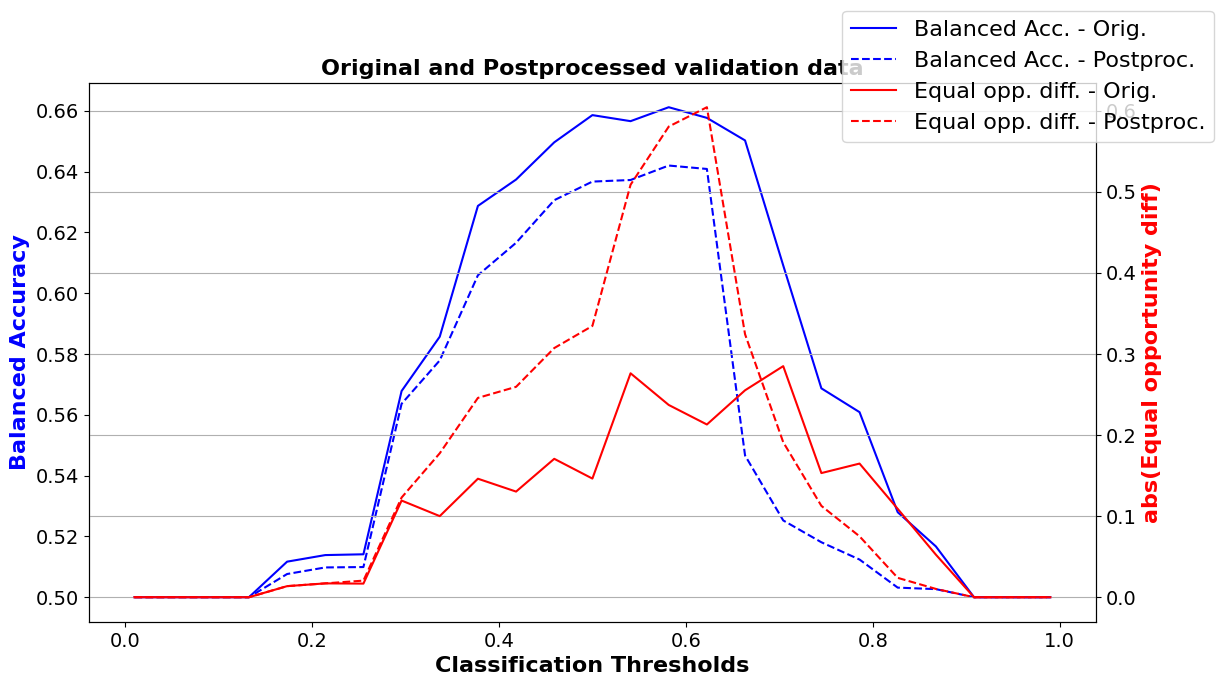

In [48]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

Overall, the classifier loses both accuraccy and fairness (equal opportunity diff is increased) after post processing

# Conclusion
After our analysis, it can be seen that there is no perfect solution for the fair classifier. The fairness increase is always accompanied with accuracy decrease which is not surprising since we are edding "errors" to data and the model achieves worse performance metrics.

Observing the preprocessing it can be seen that the transformation equalises all models to approximately the same accuracy/fairness result so it can be concluded that it is not very inportant which model this technique is better apply to.

Regarding the postprocessing, we were unable to improve the fairness scores.